<a href="https://colab.research.google.com/github/KonstantinosKounakis/EleganSeg/blob/main/1_Demo_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Feb 25 11:42:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [31]:
#@title **Install dependencies**
#@markdown It will take a few minutes.
!python -m pip install -U roifile
!pip install XlsxWriter
!pip install joblib
!pip install file-split-merge
!pip install imagecodecs
!pip install tifffile
!pip install file-split-merge

import warnings
import os
import gc
import torch
import random
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage import measure, morphology
from scipy import ndimage
import matplotlib
from PIL import Image, ImageDraw
import math
import numpy.matlib as npm
from roifile import ImagejRoi, roiwrite
from models.UMF_ConvLSTM import UMF_ConvLSTM\

from tqdm import tqdm
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tifffile

def imread_image(path_image):
    head, tail = os.path.split(path_image)
    ext = tail.split('.')[1]

    if ext == 'tif' or ext == 'tiff' or ext == 'TIF' or ext == 'TIFF':
        image = tifffile.imread(path_image)
    else:
        # image = cv2.imread(path_image, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(path_image)
    return image.astype('uint8')


def read_tiff_mask(path_image_mask):
    image_mask = tifffile.imread(path_image_mask)
    if len(image_mask.shape) == 2:
        h, w = image_mask.shape
        if image_mask.max() == 0:
            image_mask = np.zeros((0, h, w), dtype="uint8")
        else:
            image_mask = np.expand_dims(image_mask, axis=0)
    else:
        d, h, w = image_mask.shape
        if image_mask.max() == 0:
            image_mask = np.zeros((0, h, w), dtype="uint8")
    return image_mask


def save_mask_tif(path_save, img):
    if img.shape[0] == 0:
        d, h, w = img.shape
        img = np.zeros((h, w))
    tifffile.imwrite(path_save, img.astype(np.uint8))


def update_mask(true_mask, mask):
    if len(true_mask.shape) == 2:
        true_mask = mask
    else:
        true_mask = np.concatenate((true_mask, mask), axis=0)
    return true_mask


def rotate_rectangle(HH, WW, cx, cy, w, h, angle):
    value = 1
    img = Image.new('L', (WW, HH), 0)
    theta = math.radians(angle)
    bbox = npm.repmat([[cx], [cy]], 1, 5) + \
           np.matmul([[math.cos(theta), math.sin(theta)],
                      [-math.sin(theta), math.cos(theta)]],
                     [[-w / 2, w / 2, w / 2, -w / 2, w / 2 + 8],
                      [-h / 2, -h / 2, h / 2, h / 2, 0]])

    x1, y1 = bbox[0][0], bbox[1][0]  # add first point
    x2, y2 = bbox[0][1], bbox[1][1]  # add second point
    x3, y3 = bbox[0][2], bbox[1][2]  # add third point
    x4, y4 = bbox[0][3], bbox[1][3]  # add forth point
    polygon = [x1, y1, x2, y2, x3, y3, x4, y4]
    ImageDraw.Draw(img).polygon(polygon, outline=value, fill=value)
    return np.asarray(img)


def setps_crop(h, in_size, max_crops):
    diff_h = h - in_size

    steps = []
    for i in range(2, max_crops):
        if diff_h % i == 0:
            steps.append(i)

    step_i = int(diff_h / steps[-1])
    v_step = []
    for i in range(steps[-1] + 1):
        v_step.append(i * step_i)
    return v_step


def build_skel(H, W, XY_skels):
    mask = np.zeros((H, W))
    for XY_skel in XY_skels:
        mask[int(XY_skel[0]), int(XY_skel[1])] = 1
    return mask


def list_files(path, extension):
    res = []
    # Iterate directory
    for file in os.listdir(path):
        # check only text files
        if file.endswith(extension):
            res.append(file)
    return res


def labels_list(label_segmentation):
    list_parts = list(np.unique(label_segmentation))
    labels_list_noneZero = []
    for i in list_parts:
        if i != 0:
            labels_list_noneZero.append(i)
    return labels_list_noneZero


def get_image_network(device, dir_checkpoint, n_classes, in_size, image_gray, batch_img):
    model = UMF_ConvLSTM(n_channels=1, n_classes=n_classes, bilinear=True, type_net=1)
    model.load_state_dict(torch.load(dir_checkpoint))
    model.eval()
    model.to(device=device)

    h, w = image_gray.shape
    h_steps = setps_crop(h, in_size, 3)
    w_steps = setps_crop(w, in_size, 3)
    list_box = []
    for i in h_steps:
        for j in w_steps:
            crop = [i, i + in_size, j, j + in_size]
            list_box.append(crop)

    n_crops = len(list_box)
    n_reps = 1
    f = 0
    while f == 0:
        if (batch_img * n_reps) < n_crops:
            n_reps = n_reps + 1
        else:
            f = 1

    if n_classes == 1:
        masK_img = np.zeros((h, w), dtype="uint8")

    if n_classes == 4:
        masK_img = np.zeros((h, w, 3), dtype="uint8")

    with torch.no_grad():
        cnt_crops1 = 0
        cnt_crops2 = 0
        for i in range(n_reps):
            masK_crops = np.zeros((h, w), dtype="uint8")
            for j in range(batch_img):
                if cnt_crops1 < n_crops:
                    image_i = image_gray[list_box[cnt_crops1][0]:list_box[cnt_crops1][1], list_box[cnt_crops1][2]:list_box[cnt_crops1][3]]
                    image_i = np.expand_dims(image_i, axis=0)
                    masK_crops = update_mask(masK_crops, image_i)
                    cnt_crops1 = cnt_crops1 + 1

            image_i = torch.from_numpy(masK_crops).to(device=device, dtype=torch.float32).unsqueeze(1)
            image_i = model(image_i)
            image_i = (torch.sigmoid(image_i) > 0.5) * 255
            image_i = image_i.cpu().numpy().astype('uint8')

            for j in range(batch_img):
                if cnt_crops2 < n_crops:
                    if n_classes == 1:
                        masK_img[list_box[cnt_crops2][0]:list_box[cnt_crops2][1], list_box[cnt_crops2][2]:list_box[cnt_crops2][3]] = image_i[j, :, :, :]

                    if n_classes == 4:
                        masK_img[list_box[cnt_crops2][0]:list_box[cnt_crops2][1], list_box[cnt_crops2][2]:list_box[cnt_crops2][3], 0] = image_i[j, 1, :, :]
                        masK_img[list_box[cnt_crops2][0]:list_box[cnt_crops2][1], list_box[cnt_crops2][2]:list_box[cnt_crops2][3], 1] = image_i[j, 2, :, :]
                        masK_img[list_box[cnt_crops2][0]:list_box[cnt_crops2][1], list_box[cnt_crops2][2]:list_box[cnt_crops2][3], 2] = image_i[j, 3, :, :]
                    cnt_crops2 = cnt_crops2 + 1

    del model, image_i, masK_crops
    gc.collect()
    torch.cuda.empty_cache()
    return masK_img


def build_edge(image_bw):
    H, W = image_bw.shape
    image_bw = ((image_bw > 0) * 255).astype('uint8')
    contours, hierarchy = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for j in range(len(contours)):
        XY = contours[j][:, 0, :]
        X = XY[:, 0]
        Y = XY[:, 1]
        XY = np.stack((Y, X), axis=-1)
        if j == 0:
            XY_points = XY
        else:
            XY_points = np.vstack((XY_points, XY))

    if len(contours) > 0:
        SKL = build_skel(H, W, XY_points)
    else:
        SKL = np.zeros((H, W), dtype="uint8")
    return ((SKL > 0) * 255).astype('uint8')


def edge_img(img):
    # create edge
    masK_edge = np.zeros((img.shape[0], img.shape[1]), dtype="uint8")
    masK_edge[0:img.shape[0], 0:1] = 255
    masK_edge[0:img.shape[0], img.shape[1] - 1:img.shape[1]] = 255

    masK_edge[0:1, 0:img.shape[1]] = 255
    masK_edge[img.shape[0] - 1:img.shape[0], 0:img.shape[1]] = 255
    return masK_edge


def skeleton_check_edge(img):
    masK_edge = edge_img(img)
    skeleton_fix = cv2.bitwise_and(img.astype('uint8'), cv2.bitwise_not(masK_edge))
    return skeleton_fix > 0


def check_edge_worms(image_seg, kernel_size):
    h, w, d = image_seg.shape
    edge_seg = image_seg[:, :, 2]
    edge_worm = build_edge(image_seg[:, :, 0])

    try:
        edge_overlap = build_edge(image_seg[:, :, 1])
    except:
        edge_overlap = np.zeros((h, w), dtype="uint8")
    edge_final = (((edge_seg + edge_worm + edge_overlap) > 0) * 255).astype('uint8')

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    edge_final = cv2.dilate(edge_final.astype('uint8'), kernel, iterations=1)
    edge_final = cv2.erode(edge_final.astype('uint8'), kernel, iterations=1)
    return edge_final


def obtain_overlappings(image_seg, edge_final, kernel_size):
    # Obtain none overlapings and overlappings
    worms_seg = (image_seg[:, :, 0] > 0) * 1
    edge_overlap_seg = ((edge_final + image_seg[:, :, 1]) == 0) * 1
    none_overlappings = worms_seg * edge_overlap_seg

    overlapping_parts = (image_seg[:, :, 1] > 0) * 255

    kernel_overlap = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    overlapping_parts_dilated = cv2.dilate(overlapping_parts.astype('uint8'), kernel_overlap, iterations=2)
    overlapping = (overlapping_parts_dilated > 0) * 1
    return none_overlappings, overlapping


def branchs_endpoints(img):
    (rows, cols) = np.nonzero(img)  # Find row and column locations that are non-zero
    skel_coords_branch = []  # Initialize empty list of co-ordinates branch
    skel_coords_endpoints = []  # Initialize empty list of co-ordinates endpoints

    # For each non-zero pixel...
    for (r, c) in zip(rows, cols):
        # Extract an 8-connected neighbourhood
        (col_neigh, row_neigh) = np.meshgrid(np.array([c - 1, c, c + 1]), np.array([r - 1, r, r + 1]))

        # Cast to int to index into image
        col_neigh = col_neigh.astype('int')
        row_neigh = row_neigh.astype('int')

        # Convert into a single 1D array and check for non-zero locations
        pix_neighbourhood = img[row_neigh, col_neigh].ravel() != 0

        # If the number of non-zero locations equals 2, add this to
        # our list of co-ordinates
        if np.sum(pix_neighbourhood) > 3:
            skel_coords_branch.append((r, c))

        # If the number of non-zero locations equals 2, add this to
        # our list of co-ordinates
        if np.sum(pix_neighbourhood) == 2:
            skel_coords_endpoints.append((r, c))
    return skel_coords_branch, skel_coords_endpoints


def check_overlapping(labels_overlapping, labels_none_overlapping):
    h, w = labels_overlapping.shape
    masK_delete_overlaps = np.zeros((h, w))
    skeleton_overlap = skeletonize((labels_overlapping > 0) * 1) * 1
    skeleton_overlap = skeleton_check_edge(skeleton_overlap) * 255

    for i in range(1, labels_overlapping.max() + 1):
        overlap_i = (labels_overlapping == i) * 1

        list_branch, _ = branchs_endpoints((overlap_i * skeleton_overlap) > 0)
        if len(list_branch) == 0:
            masK_delete_overlaps = masK_delete_overlaps + overlap_i

    # check again overlapping connections
    true_overlaps = (masK_delete_overlaps > 0) * 1
    true_overlaps1 = ((true_overlaps == 0) * 1) * labels_overlapping

    blobs_labels_overlaps = measure.label((true_overlaps1 > 0) * 1, background=0)
    for i in range(len(blobs_labels_overlaps) + 1):
        if i != 0:
            overlap_i = (blobs_labels_overlaps == i) * 1
            worms_connected_overlap = overlap_i * labels_none_overlapping
            worms_connected_overlap = labels_list(worms_connected_overlap)

            if len(worms_connected_overlap) < 2:
                masK_delete_overlaps = masK_delete_overlaps + overlap_i
    true_overlaps = (masK_delete_overlaps > 0) * 1
    true_overlaps1 = ((true_overlaps == 0) * 1) * labels_overlapping
    return (true_overlaps1 > 0) * 1


def get_none_overlapping(labels_none_overlapping, true_overlaps, area_min, kernel_size):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    true_overlaps_ic = np.copy(true_overlaps)
    true_overlaps_ic = cv2.dilate(((true_overlaps_ic > 0) * 255).astype('uint8'), kernel, iterations=1)

    worms_overlaps = ((true_overlaps_ic > 0) * 1) * labels_none_overlapping
    overlap_parts = labels_list(worms_overlaps)
    all_elements = []
    for i in range(labels_none_overlapping.max() + 1):
        if i != 0:
            all_elements.append(i)

    all_elements1 = all_elements + overlap_parts
    None_overlap_parts = [i for i in all_elements if all_elements1.count(i) == 1]

    # select worms > 600 pixeles (area)
    h, w = labels_none_overlapping.shape
    mask_true_worms = np.zeros((h, w))
    for i in None_overlap_parts:
        part_i = (labels_none_overlapping == i) * 1
        count_px = np.count_nonzero(part_i > 0)
        if count_px > area_min:
            mask_true_worms = mask_true_worms + part_i
    return (mask_true_worms > 0) * 1


def get_angle(XY00, XYFF):
    angle = math.atan2(XYFF[1] - XY00[1], XYFF[0] - XY00[0]) * (180 / math.pi)
    return angle


def TwoPoints(none_overlappings_mpart, image_skl, dt_overlappings_ov_part):
    skl_none_overlappings_mpart = ((none_overlappings_mpart * image_skl) > 0) * 1
    value_skl = skl_none_overlappings_mpart * dt_overlappings_ov_part
    (rows, cols) = np.nonzero(value_skl)
    skl_val = []
    skl_px = []
    for px in range(len(rows)):
        Y = rows[px]
        X = cols[px]
        skl_val.append(value_skl[Y, X])
        skl_px.append([X, Y])

    XY_points = []
    angle = -1
    if len(skl_val) > 0:
        Value_sorted, XY_sorted = zip(*sorted(zip(skl_val, skl_px)))

        XY0 = XY_sorted[0]
        if len(XY_sorted) > 10:
            XYF = XY_sorted[10]
        else:
            XYF = XY_sorted[-1]

        XY_points = [XY0, XYF]
        angle = get_angle(XYF, XY0)
    return XY_points, angle


def connected_parts(none_overlappings_part, overlappings_ov_part, none_overlappings_i, image_skl, angle_value):
    dt_overlappings_ov_part = ndimage.distance_transform_edt((overlappings_ov_part == 0) * 1)
    XY_points0, angle0 = TwoPoints(none_overlappings_part, image_skl, dt_overlappings_ov_part)

    none_overlappings_ov_parts = overlappings_ov_part * none_overlappings_i * ((none_overlappings_part == 0) * 1)
    none_overlappings_ov_list = labels_list(none_overlappings_ov_parts)

    XY_none_overlap = []
    angle_none_overlap = []
    id_part = []
    for mpart in none_overlappings_ov_list:
        none_overlappings_mpart = (none_overlappings_i == mpart) * 1  # labels_none_overlapping
        XY_points, angle = TwoPoints(none_overlappings_mpart, image_skl, dt_overlappings_ov_part)
        if len(XY_points) > 0:
            XY_none_overlap.append(XY_points)
            angle_none_overlap.append(angle)
            id_part.append(mpart)

    # select best part
    list_angles = []
    if len(XY_points0) > 0:
        for i in range(len(XY_none_overlap)):
            XY_pointsF = XY_none_overlap[i]
            angleF = get_angle(XY_points0[0], XY_pointsF[0])
            diff_angle = abs(angle0 - angleF)
            list_angles.append(diff_angle)

    best_id_part = 0
    best_points = []
    if len(XY_points0) > 0:
        best_points = [XY_points0[0]]
    if len(list_angles) > 0:
        min_angle = min(list_angles)
        if min_angle < angle_value:  # 22
            best_idex = list_angles.index(min_angle)
            best_id_part = id_part[best_idex]
            best_points.append(XY_none_overlap[best_idex][0])
    return best_id_part, best_points


def connection_overlap(conecction_points, overlappings_ov_part, none_overlappings_part):
    ci = conecction_points[0]
    cf = conecction_points[1]
    dt_overlap_i = ndimage.distance_transform_edt((overlappings_ov_part > 0) * 1)

    cx = ci[0] - (ci[0] - cf[0]) / 2
    cy = ci[1] - (ci[1] - cf[1]) / 2
    angle = get_angle([cx, cy], ci)

    wr = math.sqrt(((abs(ci[0] - cx)) ** 2) + ((abs(ci[1] - cy)) ** 2))
    hR = dt_overlap_i[int(cy), int(cx)]

    h, w = overlappings_ov_part.shape
    img = rotate_rectangle(h, w, cx, cy, wr*2, hR*2, -angle)
    img = img * (((overlappings_ov_part + none_overlappings_part) > 0) * 1)
    return (img > 0) * 1


def recursive_connect_parts(list_part, masK_worm, none_overlappings_part, none_ovp, overlappings_i, none_overlappings_i, image_skl, kernel_size, angle_value):
    list_part.append(none_ovp)
    masK_worm = masK_worm + none_overlappings_part

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    none_overlappings_i = none_overlappings_i * ((none_overlappings_part == 0) * 1)

    none_overlappings_part_ic = np.copy(none_overlappings_part)
    none_overlappings_part_ic = cv2.dilate(((none_overlappings_part_ic > 0) * 255).astype('uint8'), kernel, iterations=1)
    none_overlappings_part_ic = (none_overlappings_part_ic > 0) * 1
    overlap_touch = none_overlappings_part_ic * overlappings_i
    overlappings_i_list = labels_list(overlap_touch)  # list overlap touching none-overlap
    for ovp in overlappings_i_list:
        overlappings_ov_part = (overlappings_i == ovp) * 1  # select first

        overlappings_ov_part_ic = np.copy(overlappings_ov_part)
        overlappings_ov_part_ic = cv2.dilate(((overlappings_ov_part_ic > 0) * 255).astype('uint8'), kernel, iterations=1)
        overlappings_ov_part_ic = (overlappings_ov_part_ic > 0) * 1
        best_id_part, best_points = connected_parts(none_overlappings_part_ic, overlappings_ov_part_ic,
                                                    none_overlappings_i, image_skl, angle_value)
        if best_id_part != 0:  # select next part
            # conecction_points.append(best_points)
            img_connection = connection_overlap(best_points, overlappings_ov_part, none_overlappings_part)
            masK_worm = masK_worm + img_connection

            none_overlappings_part_ovp = (none_overlappings_i == best_id_part) * 1
            overlappings_i = overlappings_i * ((overlappings_ov_part == 0) * 1)
            list_part, masK_worm = recursive_connect_parts(list_part, masK_worm, none_overlappings_part_ovp,
                                                           best_id_part, overlappings_i, none_overlappings_i,
                                                           image_skl, kernel_size, angle_value)
    return list_part, (masK_worm > 0) * 1


def overlapping_worms(true_overlaps, mask_worms, labels_overlapping, labels_none_overlapping, image_skl, area_min, kernel_size, angle_value):
    overlapping = (labels_overlapping > 0) * 1
    none_overlappings = (labels_none_overlapping > 0) * 1

    deleted_overlaps = ((true_overlaps == 0) * 1) * overlapping
    deleted_segmentation = ((mask_worms + deleted_overlaps) > 0) * 1

    worms_overlapping = ((mask_worms == 0) * 1) * none_overlappings
    all_segmentation = ((deleted_segmentation == 0) * 1) * ((overlapping + worms_overlapping) > 0) * 1
    blobs_all_segmentation = measure.label(all_segmentation, background=0)

    #  Delete none worms
    h, w = blobs_all_segmentation.shape
    delete_none_worms = np.zeros((h, w))
    connected_worms = []
    for i in range(blobs_all_segmentation.max() + 1):
        if i != 0:
            part_i = (blobs_all_segmentation == i) * 1
            count_px = np.count_nonzero((part_i * overlapping) > 0)
            if count_px == 0:
                delete_none_worms = delete_none_worms + part_i
            else:
                connected_worms.append(i)
    delete_none_worms = (delete_none_worms > 0) * 1

    # optimizer: select best parts per worm
    masK_worms = np.zeros((h, w), dtype="uint8")
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    for i in connected_worms:  # select blob
        blob_i = (blobs_all_segmentation == i) * 1
        overlappings_i = blob_i * labels_overlapping
        none_overlappings_i = blob_i * labels_none_overlapping
        none_overlappings_i_list = labels_list(none_overlappings_i)  # obtain none-overlappings parts
        for none_ovp in none_overlappings_i_list:  # part_worm not taken
            if none_ovp != 0:
                list_part = []
                # conecction_points = []
                masK_worm = np.zeros((h, w))
                none_overlappings_part = (none_overlappings_i == none_ovp) * 1  # select binary none-overlap
                overlappings_ic = np.copy(overlappings_i)
                none_overlappings_ic = np.copy(none_overlappings_i)
                list_part, masK_worm = recursive_connect_parts(list_part, masK_worm, none_overlappings_part, none_ovp,
                                                               overlappings_ic, none_overlappings_ic, image_skl,
                                                               kernel_size + 2, angle_value)
                list_part = list(np.unique(list_part))
                count_px = np.count_nonzero(masK_worm > 0)
                if count_px > area_min:
                    # update list none-overlappings and none_overlappings_i
                    for wm in list_part:
                        dx_list = none_overlappings_i_list.index(wm)

                        none_overlappings_i_list[dx_list] = 0
                    none_overlappings_i = none_overlappings_i * ((masK_worm == 0) * 1)

                    # save result
                    masK_worm = (masK_worm * 255).astype('uint8')
                    masK_worm = cv2.dilate(masK_worm, kernel, iterations=1)  # dilate to recover edge
                    masK_worm = np.expand_dims(masK_worm, axis=0)
                    masK_worms = update_mask(masK_worms, masK_worm)

    if len(masK_worms.shape) == 2:
        masK_worms = np.zeros((0, h, w), dtype="uint8")
    return masK_worms


def worms2NDims(mask_worms, kernel_size):
    h, w = mask_worms.shape
    mask_worms = (mask_worms > 0) * 1
    labels_mask_worms = measure.label(mask_worms, background=0)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    if labels_mask_worms.max() > 0:
        masK_worms_NDims = np.zeros((h, w), dtype="uint8")
        for i in range(1, labels_mask_worms.max()+1):
            mask_i = ((labels_mask_worms == i) * 255).astype('uint8')
            mask_i = cv2.dilate(mask_i, kernel, iterations=1)  # dilate to recover edge
            mask_i = np.expand_dims(mask_i, axis=0)
            masK_worms_NDims = update_mask(masK_worms_NDims, mask_i)
    else:
        masK_worms_NDims = np.zeros((0, h, w), dtype="uint8")
    return masK_worms_NDims


def Ndims2image(all_worms, init):
    # change NDims to single image
    if len(all_worms.shape) == 2:
        h, w = all_worms.shape
        d = 1
    else:
        d, h, w = all_worms.shape
    image_color = np.zeros((h, w), dtype="uint16")
    for z in range(d):
        image_color = np.where(all_worms[z] > 0, image_color + z + init, image_color)

    colors = [(0, 0, 0)]
    for i in range(255):
        R = random.randint(10, 100) / 100
        G = random.randint(10, 100) / 100
        B = random.randint(10, 100) / 100
        colors.append((R, G, B))
    new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=256)
    return image_color, new_map


def chk_endPoints_edge(worm):
    chkL = 0
    dt_worm = ndimage.distance_transform_edt(worm)
    mask_edge = (edge_img(worm) > 0) * 1

    edge_dtimg = dt_worm * mask_edge
    if edge_dtimg.max() > 4:
        chkL = 1
    return chkL


def check_noneOverlapping(mask_worms_Dims, th):
    d, h, w = mask_worms_Dims.shape
    worms_an = []
    worms_size = []
    for i in range(d):
        f_worm = 0
        worm = mask_worms_Dims[i, :, :]
        chk_edge = chk_endPoints_edge(worm)  # touching edge?
        count_px = np.count_nonzero(worm > 0)  # mesuare worm size
        if chk_edge == 0:  # is not on the edge
            f_worm = 1
        worms_an.append(f_worm)
        worms_size.append(count_px)

    if len(worms_size) == 0:
        max_size = 0
    else:
        max_size = max(worms_size)

    worms_good = np.zeros((h, w), dtype="uint8")
    worms_bads = np.zeros((h, w), dtype="uint8")

    index_good = []
    index_bad = []
    for i in range(len(worms_an)):
        worm = mask_worms_Dims[i, :, :].astype('uint8')
        worm = np.expand_dims(worm, axis=0)
        if worms_an[i] == 1:
            pSize = worms_size[i]/max_size
            if pSize >= (th/100):
                # worms_good_0 = worms_good_0 + worm[0, :, :]
                worms_good = update_mask(worms_good, worm)
                index_good.append(i)
            else:
                worms_bads = update_mask(worms_bads, worm)
                index_bad.append(i)
        else:
            worms_bads = update_mask(worms_bads, worm)
            index_bad.append(i)

    if len(worms_good.shape) == 2:
        worms_good = np.zeros((0, h, w), dtype="uint8")

    if len(worms_bads.shape) == 2:
        worms_bads = np.zeros((0, h, w), dtype="uint8")

    results = {
        # *****************
        # [masks]
        # *****************
        'worms_good': worms_good,
        'worms_bads': worms_bads,
        # *****************
        # [labels]
        # *****************
        'index_good': index_good,
        'index_bad': index_bad
    }
    return results


def get_centroid(mask, init):
    centroid = []
    label_worm = []
    if mask.shape[0] > 0:
        for i in range(mask.shape[0]):
            img00 = mask[i, :, :]
            mass_x, mass_y = np.where(img00 > 0)
            cent_x = np.average(mass_x)
            cent_y = np.average(mass_y)
            centroid.append([cent_x, cent_y])
            label_worm.append(i + init)
    return centroid, label_worm


def save_results_mask(name_image_final, image_gray, results_masks_NO, mask_overlaps_Dims, gray_color):
    init = 1
    worms_good, new_map = Ndims2image(results_masks_NO['worms_good'], init)
    centroid_good, label_good = get_centroid(results_masks_NO['worms_good'], init)

    init1 = init + results_masks_NO['worms_good'].shape[0]
    worms_bads, _ = Ndims2image(results_masks_NO['worms_bads'], init1)
    centroid_bads, label_bads = get_centroid(results_masks_NO['worms_bads'], init1)

    init2 = init1 + results_masks_NO['worms_bads'].shape[0]
    worms_overlap, _ = Ndims2image(mask_overlaps_Dims, init2)
    centroid_overlap, label_overlap = get_centroid(mask_overlaps_Dims, init2)

    font = {'family': 'serif',
            'color': 'white',
            'weight': 'bold',
            'size': 8,
            }

    plt.ioff()  # Turn interactive plotting off
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Gray image')
    if gray_color == 1:
        ax1.imshow(image_gray, cmap='gray', vmin=0, vmax=255)
    else:
        ax1.imshow(image_gray, cmap='magma')

    ax2 = fig.add_subplot(222)
    ax2.title.set_text('Complete masks')
    ax2.imshow(worms_good, cmap=new_map, interpolation='None')
    for i in range(len(centroid_good)):
        ax2.text(centroid_good[i][1], centroid_good[i][0], label_good[i], fontdict=font,
                 bbox=dict(facecolor='black', edgecolor='red', linewidth=2))

    ax3 = fig.add_subplot(223)
    ax3.title.set_text('Edge and small mask')
    ax3.imshow(worms_bads, cmap=new_map, interpolation='None')
    for i in range(len(centroid_bads)):
        ax3.text(centroid_bads[i][1], centroid_bads[i][0], label_bads[i], fontdict=font,
                 bbox=dict(facecolor='black', edgecolor='red', linewidth=2))

    ax4 = fig.add_subplot(224)
    ax4.title.set_text('Overlap masks')
    ax4.imshow(worms_overlap, cmap=new_map, interpolation='None')
    for i in range(len(centroid_overlap)):
        ax4.text(centroid_overlap[i][1], centroid_overlap[i][0], label_overlap[i], fontdict=font,
                 bbox=dict(facecolor='black', edgecolor='red', linewidth=2))
    # plt.show()
    plt.savefig(name_image_final)
    plt.close()


def save_mask_rois(path_save_rois, mask_worms_Dims):
    list_rois = []
    for i in range(mask_worms_Dims.shape[0]):
        image_bw = ((mask_worms_Dims[i, :, :] > 0) * 255).astype('uint8')
        contours = measure.find_contours(image_bw, 0.8)

        # select bigger contour
        contours_size = []
        for j in range(len(contours)):
            contours_size.append(len(contours[j]))

        max_value = max(contours_size)
        max_index = contours_size.index(max_value)

        contour = contours[max_index]
        X = contour[:, 0]
        Y = contour[:, 1]
        XY = np.stack((Y, X), axis=-1)
        roi = ImagejRoi.frompoints(XY)
        list_rois.append(roi)

    if len(list_rois) != 0:
        roiwrite(path_save_rois, list_rois)


def img2edge(image):
    h, w = image.shape
    bw = np.copy(image)
    bw = ((bw > 0) * 255).astype('uint8')

    contours, hierarchy = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for j in range(len(contours)):
        XY = contours[j][:, 0, :]
        X = XY[:, 0]
        Y = XY[:, 1]
        XY = np.stack((Y, X), axis=-1)
        XY = np.stack((Y, X), axis=-1)
        if j == 0:
            XY_points = XY
        else:
            XY_points = np.vstack((XY_points, XY))

    return build_skel(h, w, XY_points)


def NDims2worms(mask):
    if len(mask.shape) > 2:
        d, h, w = mask.shape
    else:
        h, w = mask.shape
        d = 1

    masK_worms = np.zeros((h, w), dtype="uint8")
    for gt_i in range(d):
        if len(mask.shape) > 2:
            masK_worms = masK_worms + mask[gt_i, :, :]
        else:
            masK_worms = mask

    masK_worms = (masK_worms > 0) * 1
    return masK_worms


def iou_img(I1, I2):
    IoU_dec = 0
    I1 = ((I1 > 0) * 255).astype(np.uint8)
    I2 = ((I2 > 0) * 255).astype(np.uint8)

    AND = cv2.bitwise_and(I1, I2)
    OR = cv2.bitwise_or(I1, I2)
    C0_and = np.count_nonzero(AND > 0)
    C0_or = np.count_nonzero(OR > 0)
    if C0_or != 0:
        IoU_dec = C0_and / C0_or

    return IoU_dec


def IoU_per_worm(image_masK_ground_truth, masK_predict_all, Per_value):
    IoU_worms_gt = [0 for a in range(image_masK_ground_truth.shape[0])]
    IoU_worms_pred = [0 for a in range(masK_predict_all.shape[0])]
    IoU_worms_perc = [0 for a in range(image_masK_ground_truth.shape[0])]
    for i_iou in range(image_masK_ground_truth.shape[0]):
        GT = image_masK_ground_truth[i_iou, :, :]
        IoU_temp = []
        for j_iou in range(masK_predict_all.shape[0]):
            if IoU_worms_pred[j_iou] == 0:
                pred = masK_predict_all[j_iou, :, :]
                IoU_temp.append(iou_img(GT, pred))
            else:
                IoU_temp.append(0)

        if len(IoU_temp) > 0:
            max_j = max(IoU_temp)
            if max_j > Per_value:
                IoU_index = IoU_temp.index(max_j)
                IoU_worms_pred[IoU_index] = max_j
                IoU_worms_gt[i_iou] = max_j
                IoU_worms_perc[i_iou] = 1

    avg_per_worm = sum(IoU_worms_gt) / len(IoU_worms_gt)
    avg_pecetage = sum(IoU_worms_perc) / len(IoU_worms_perc)
    return avg_per_worm, avg_pecetage

warnings.filterwarnings('ignore')

try:
  os.mkdir('/content/EleganSeg')
except FileExistsError:
  pass

!git clone https://github.com/KonstantinosKounakis/EleganSeg.git
%cd /content/EleganSeg/

fatal: destination path 'EleganSeg' already exists and is not an empty directory.
/content/EleganSeg


In [32]:
#@title **Please, provide the necessary input files below:**

base = '/content/EleganSeg/'
## #@param {type:"string"}

checkpoint_SEG = '/content/EleganSeg/Data/network/SEG/'
## #@param {type:"string"}
checkpoint_SKL = '/content/EleganSeg/Data/network/SKL/'
## #@param {type:"string"}

test_images = '/content/drive/MyDrive/Mask images/pL/' #@param {type:"string"}
print('Input folder:', test_images)

## test_mask = '/content/EleganSeg/Data/demo_images/' #@param {type:"string"}
## print('Masks tagged:', test_mask)

save_dir = '/content/drive/MyDrive/Mask Images/pL/Output/' #@param {type:"string"}
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
print('Output:', save_dir)

Input folder: /content/drive/MyDrive/Mask images/pL/
Output: /content/drive/MyDrive/Mask Images/pL/Output/


In [20]:
#@title **Unzip networks, images**
import zipfile

# unzip networks
network_SEG = checkpoint_SEG + 'model.pth'
!file_split_merge -m -i $network_SEG

network_SKL = checkpoint_SKL + 'model.pth'
!file_split_merge -m -i $network_SKL

# unzip premade masks
## mask_zip = test_mask + 'mask.zip'
## path_save_maks = test_mask + 'masks/'

## with zipfile.ZipFile(mask_zip, 'r') as zip_ref:
    ## zip_ref.extractall(path_save_maks)

##test_mask = path_save_maks


------------- STARTING FILE MERGE -------------

Merging the file to /content/EleganSeg/Data/network/SEG/model.pth
File Already Exist. Please remove the /content/EleganSeg/Data/network/SEG/model.pth and then re-run.

Do you want to remove the file [Y/N] : y
Found 3 file(s) for merging
 - Merging model.pth-1.ros file
 - Merging model.pth-2.ros file
 - Merging model.pth-3.ros file
Checking if the files are merged properly
File check : Passed
File Merged successfully
Complete in 62 seconds

------------- STARTING FILE MERGE -------------

Merging the file to /content/EleganSeg/Data/network/SKL/model.pth
File Already Exist. Please remove the /content/EleganSeg/Data/network/SKL/model.pth and then re-run.

Do you want to remove the file [Y/N] : y
Found 3 file(s) for merging
 - Merging model.pth-1.ros file
 - Merging model.pth-2.ros file
 - Merging model.pth-3.ros file
Checking if the files are merged properly
File check : Passed
File Merged successfully
Complete in 3 seconds


cuda


100%|██████████| 44/44 [00:03<00:00, 13.88img/s]

 
Image shown: pL_Bottom Slide_D_p00_0_A01f43d4.TIF


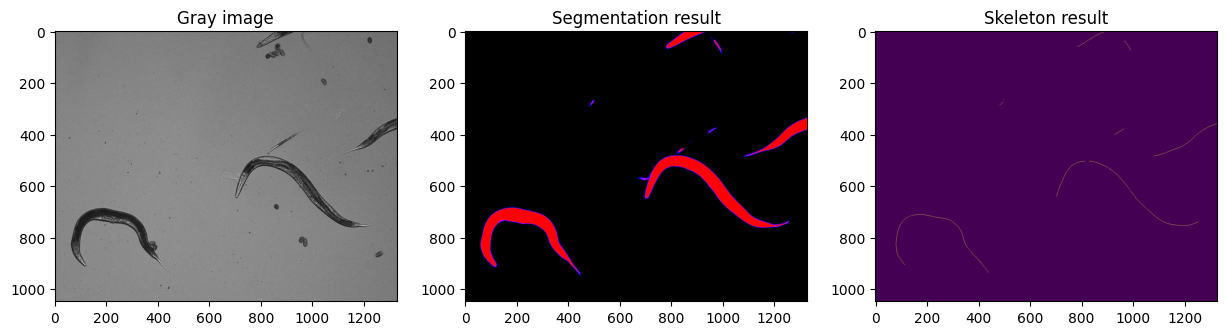

100%|██████████| 44/44 [00:03<00:00, 11.11img/s]


In [33]:
#@title **Begin Evaluating**

end_gray_image = '.TIF' #@param {type:"string"}
batch_crop_img = 9 #@param {type: "integer"}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

path_SKELETON = save_dir + '0_SKELETON/'
path_SEGMENTATION = save_dir + '0_SEGMENTATION/'

if not os.path.exists(path_SKELETON):
    os.makedirs(path_SKELETON)

if not os.path.exists(path_SEGMENTATION):
    os.makedirs(path_SEGMENTATION)

list_images = sorted(list_files(test_images, end_gray_image))

with tqdm(total=len(list_images), unit='img') as pbar:
    for name_image in list_images:
        # name_image = list_images[q]
        name_image_ = name_image.split('.')[0]
        name_image_save = name_image_ + '.bmp'
        path_image_gray = test_images + name_image

        image_gray = np.asarray(Image.open(path_image_gray))  # read gray image
        if len(image_gray.shape) > 2:
            image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)
        h, w = image_gray.shape

        if not os.path.exists(path_SEGMENTATION + name_image_save):
            # Obtain segmentation from Network1
            dir_checkpoint_seg = checkpoint_SEG + 'model.pth'
            image_seg = get_image_network(device=device, dir_checkpoint=dir_checkpoint_seg, n_classes=4,
                                            in_size=512, image_gray=image_gray, batch_img=batch_crop_img)

            # Obtain Skeleton from Network2
            dir_checkpoint_skl = checkpoint_SKL + 'model.pth'
            image_skl = get_image_network(device=device, dir_checkpoint=dir_checkpoint_skl, n_classes=1,
                                            in_size=512, image_gray=image_gray, batch_img=batch_crop_img)
            cv2.imwrite(path_SEGMENTATION + name_image_save, image_seg)
            cv2.imwrite(path_SKELETON + name_image_save, image_skl)
        else:
            image_seg = cv2.imread(path_SEGMENTATION + name_image_save)
            image_skl = cv2.imread(path_SKELETON + name_image_save, cv2.IMREAD_GRAYSCALE)
        pbar.update(1)

    print(' ')
    print('Image shown:', name_image)
    name_image_00 = name_image
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(131)
    ax1.title.set_text('Gray image')
    ax1.imshow(image_gray, cmap='gray', vmin=0, vmax=255)

    ax2 = fig.add_subplot(132)
    ax2.title.set_text('Segmentation result')
    ax2.imshow(image_seg)

    ax3 = fig.add_subplot(133)
    ax3.title.set_text('Skeleton result')
    ax3.imshow(image_skl)
    plt.show()

Folder complete mask: /content/drive/MyDrive/Mask Images/pL/Output/1_complete_mask/
Folder edge and small mask: /content/drive/MyDrive/Mask Images/pL/Output/1_edge_small_mask/
Folder overlap masks: /content/drive/MyDrive/Mask Images/pL/Output/1_overlap/
Folder save_results: /content/drive/MyDrive/Mask Images/pL/Output/0_RGB_results/


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 out of  44 | elapsed:  3.1min finished


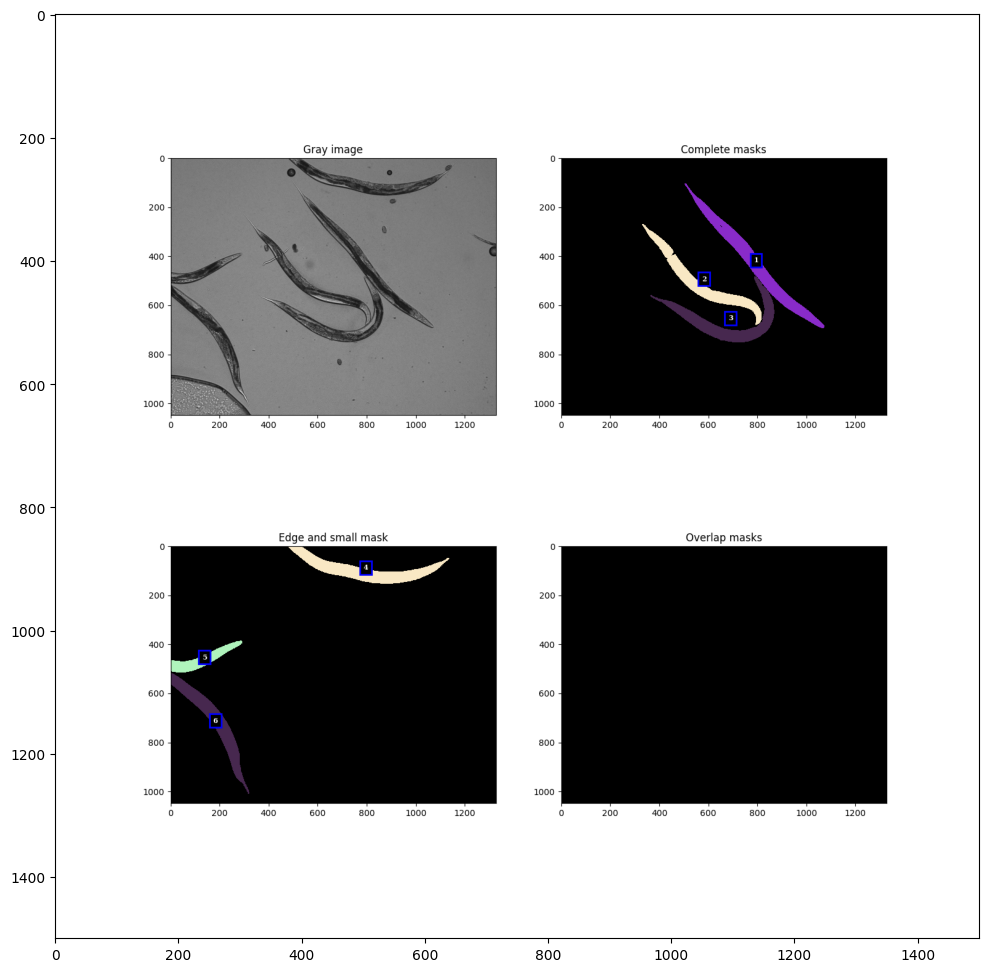

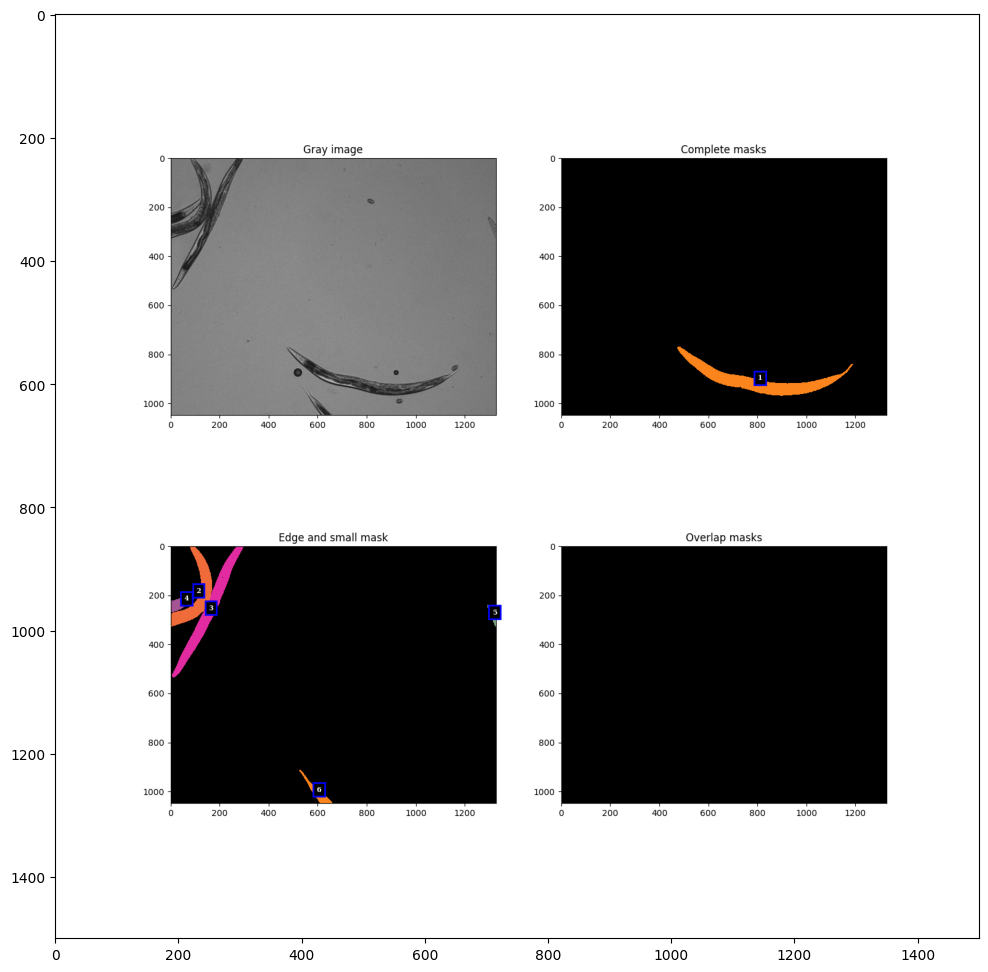

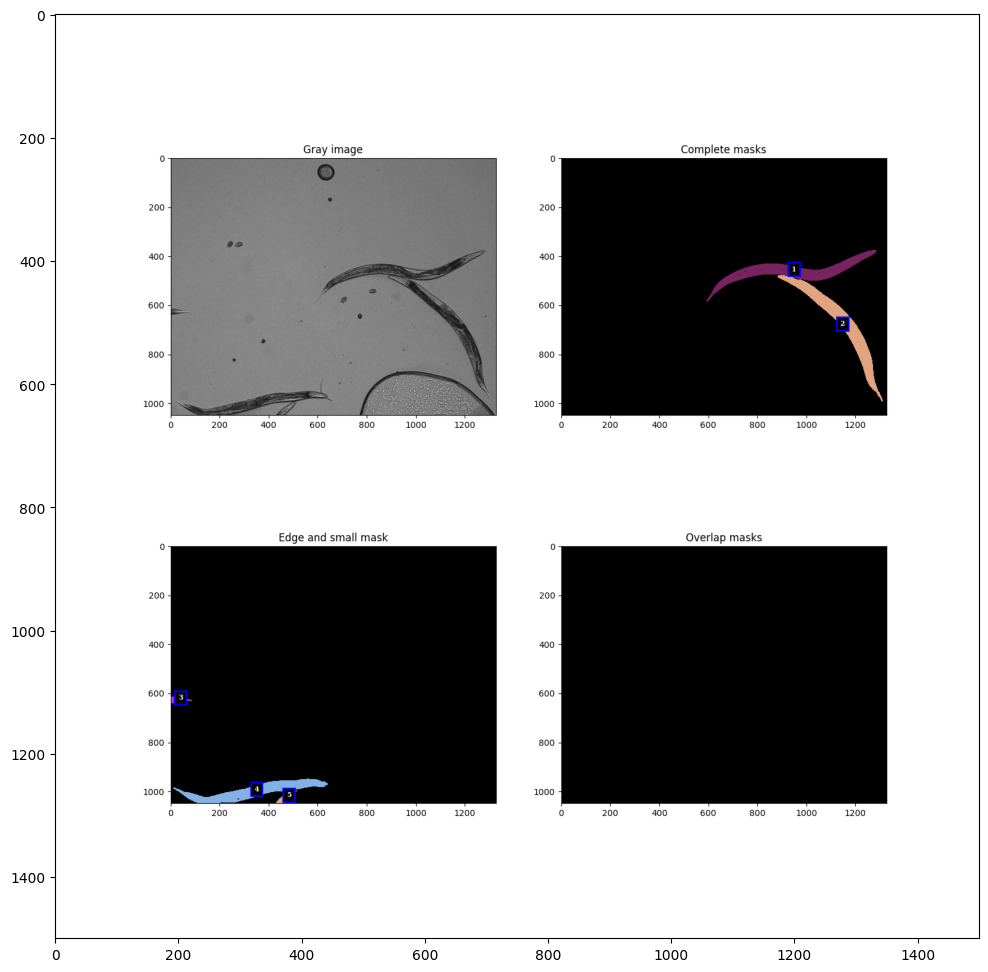

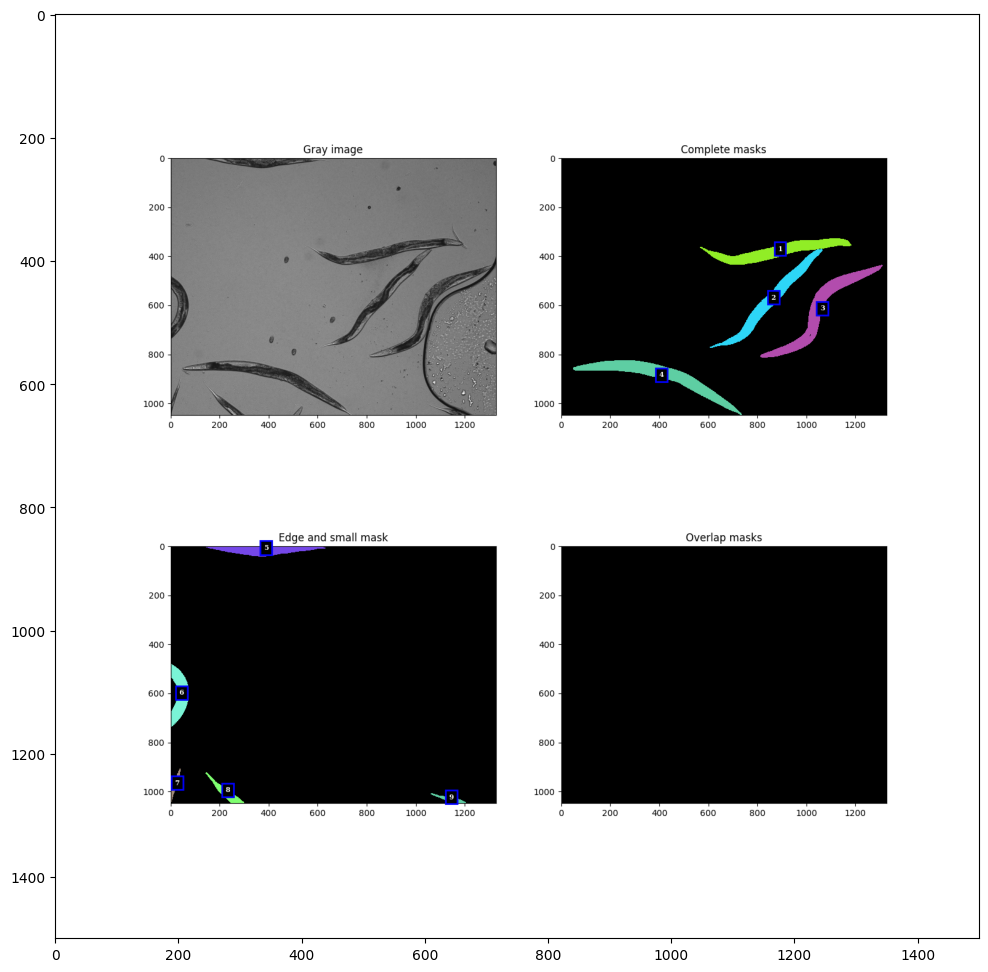

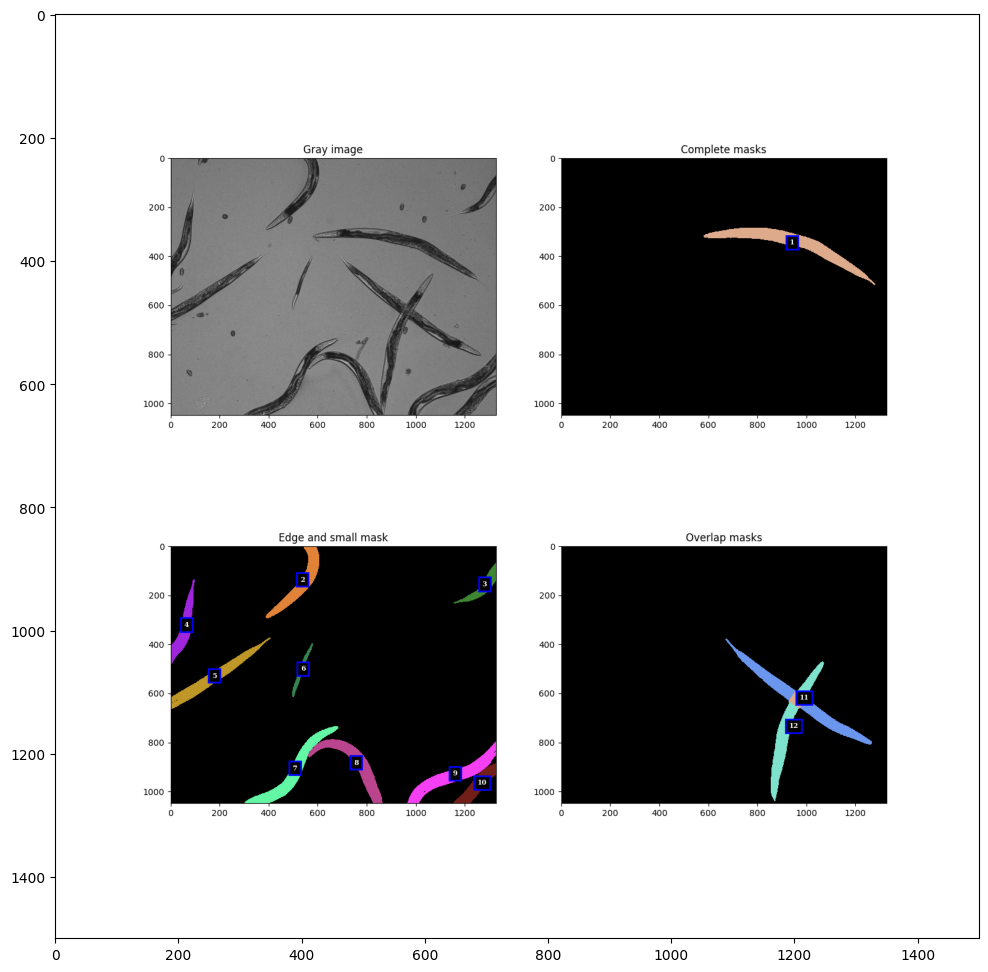

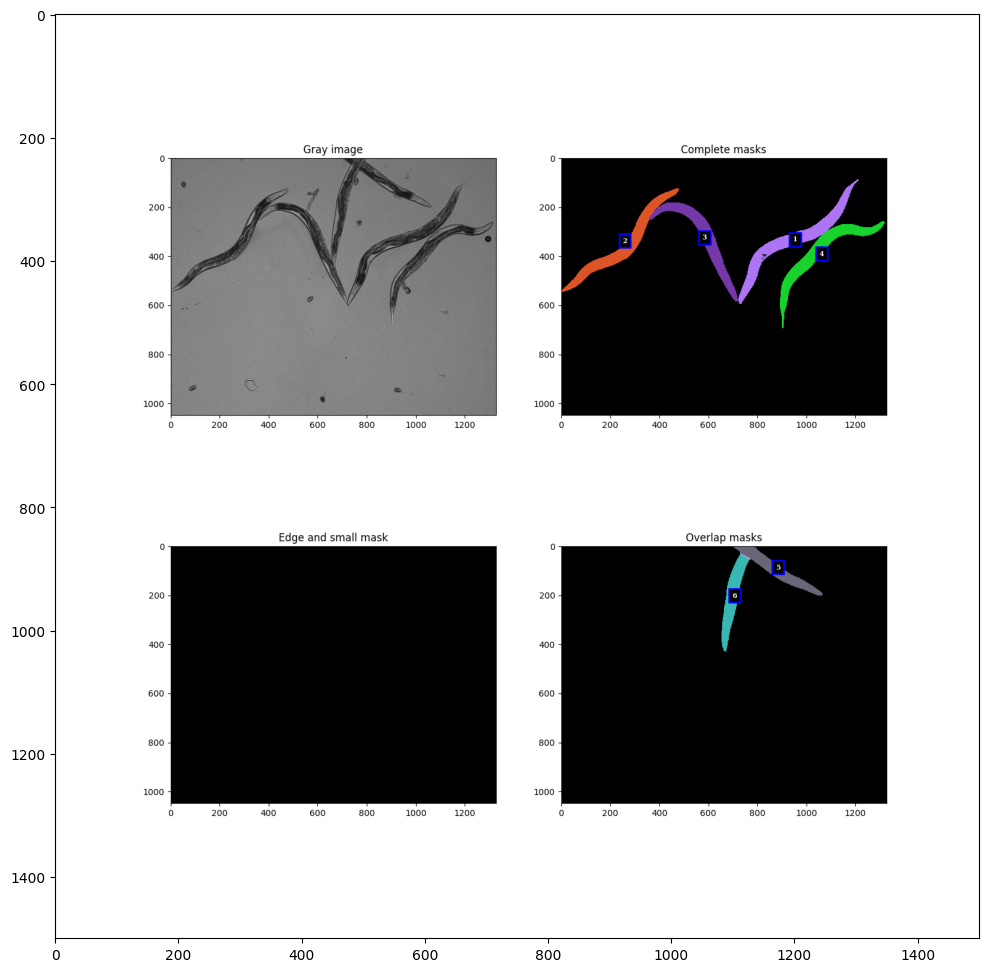

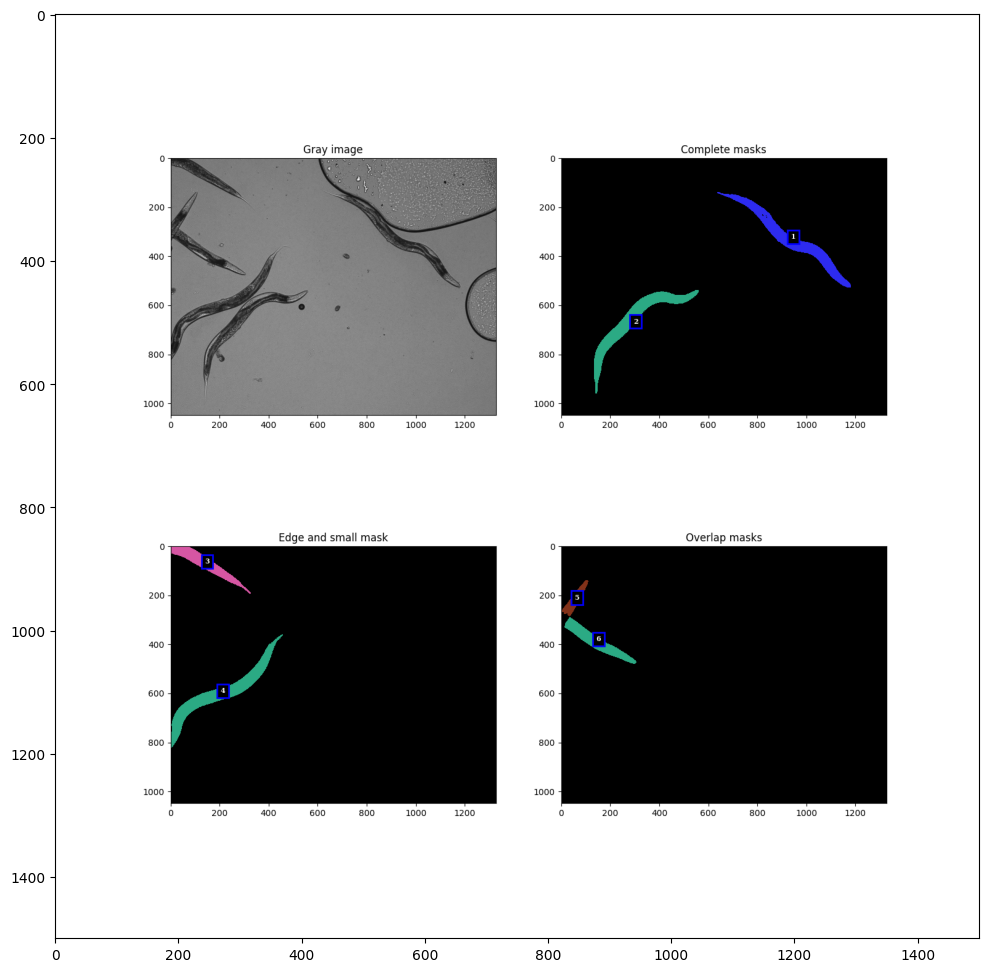

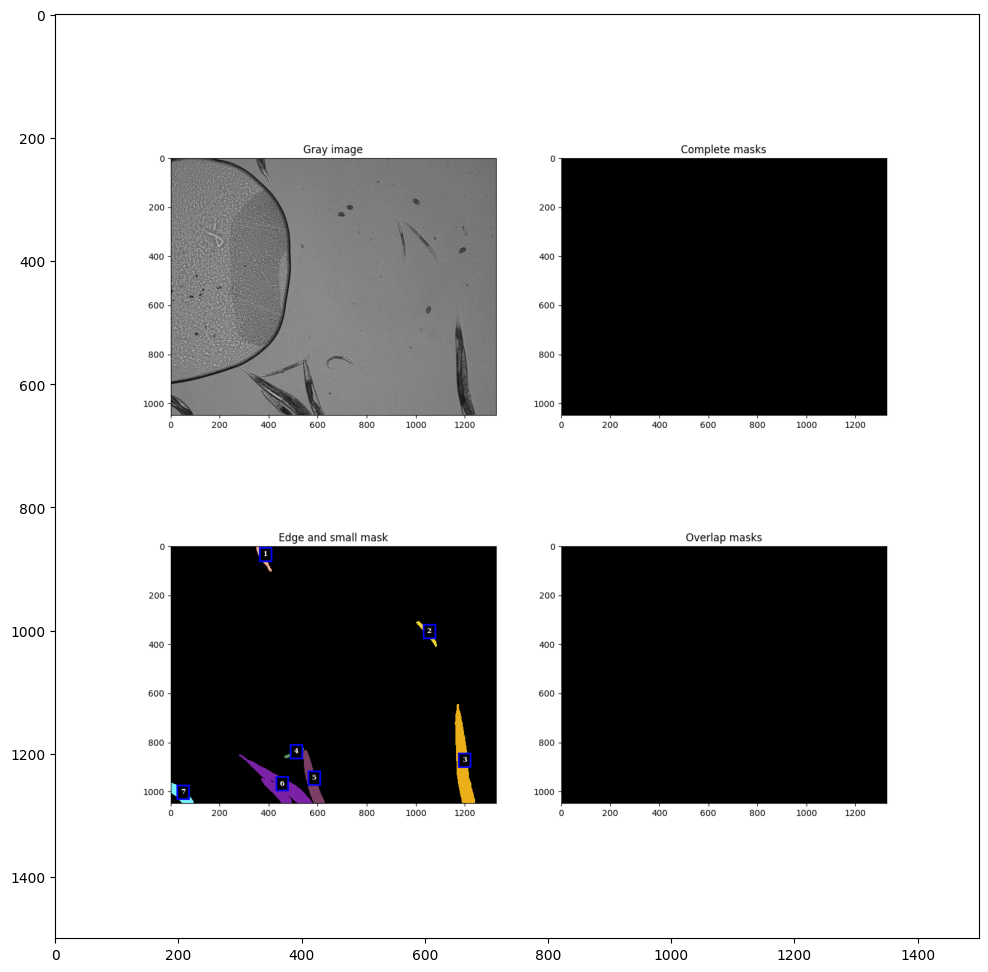

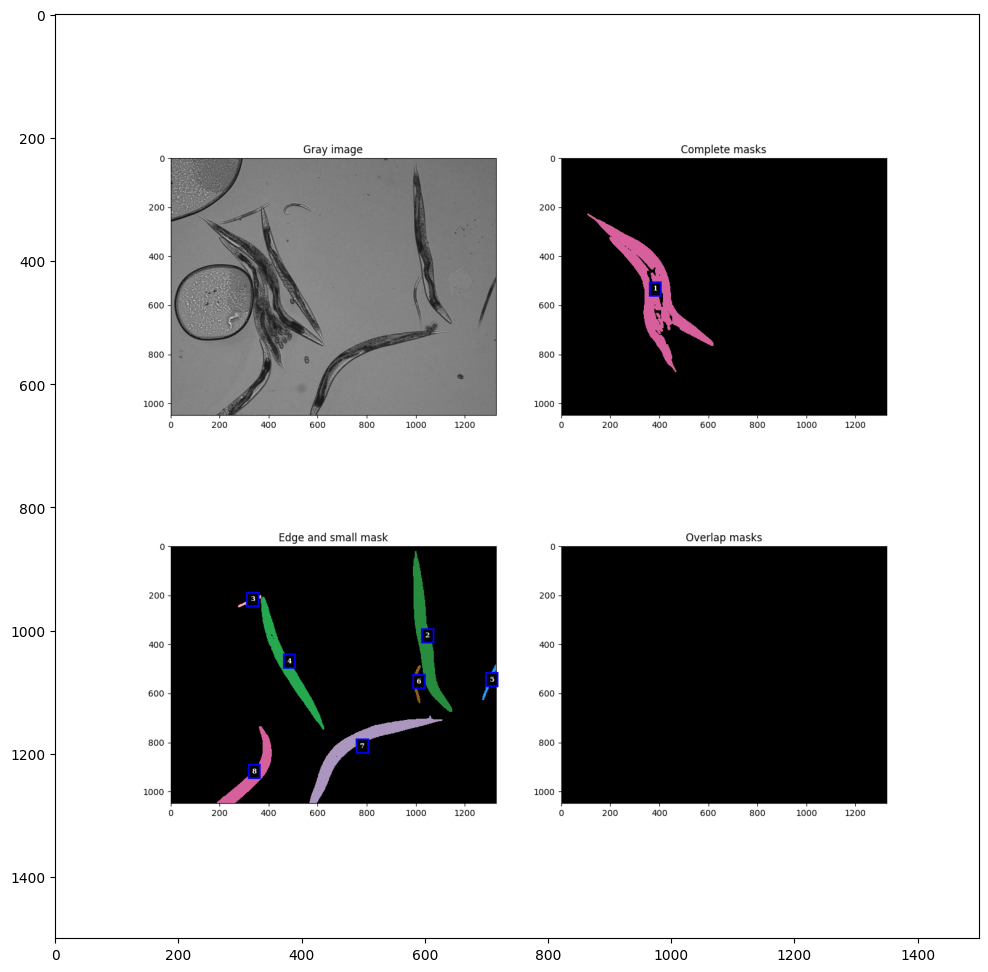

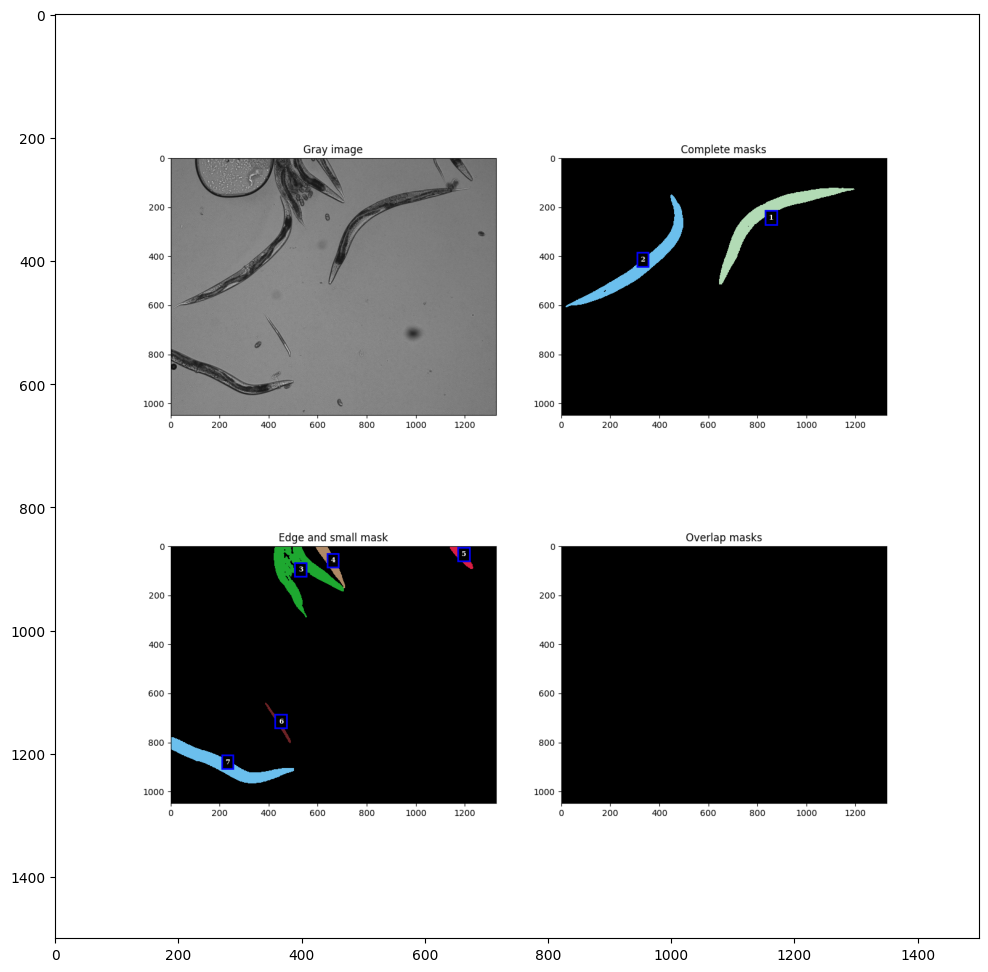

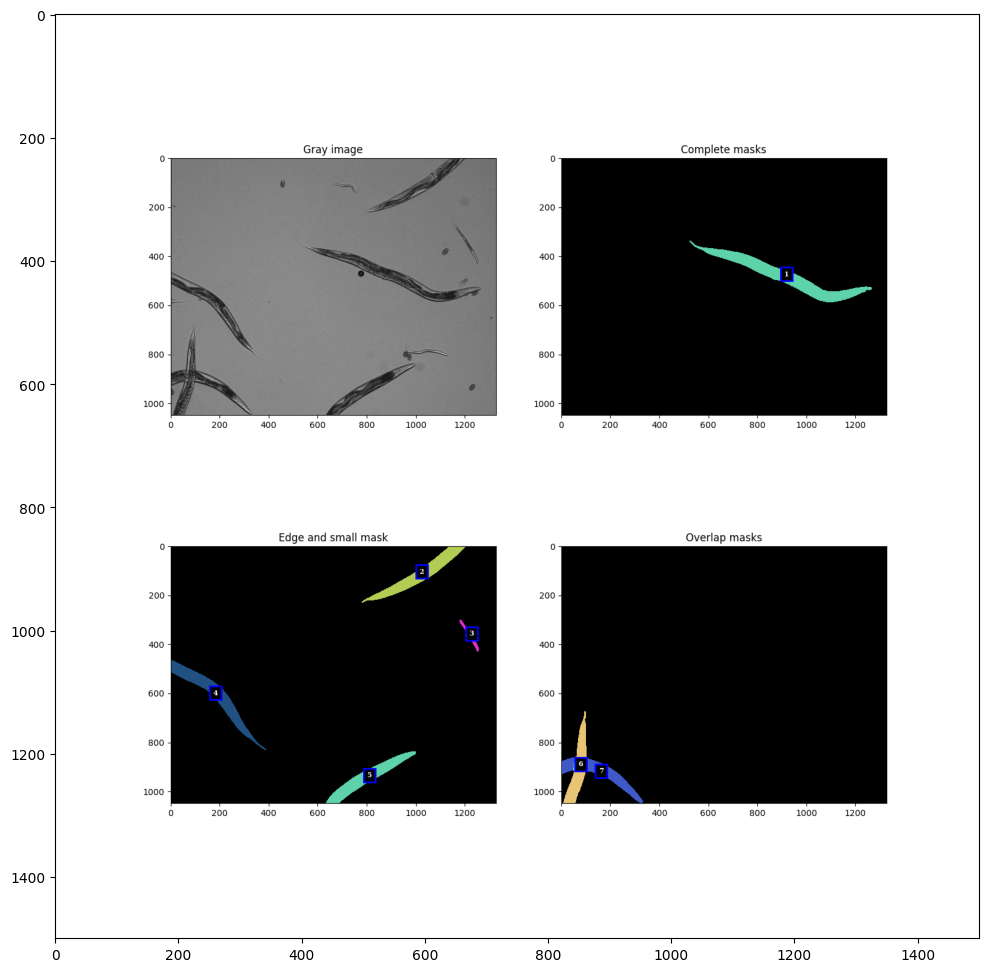

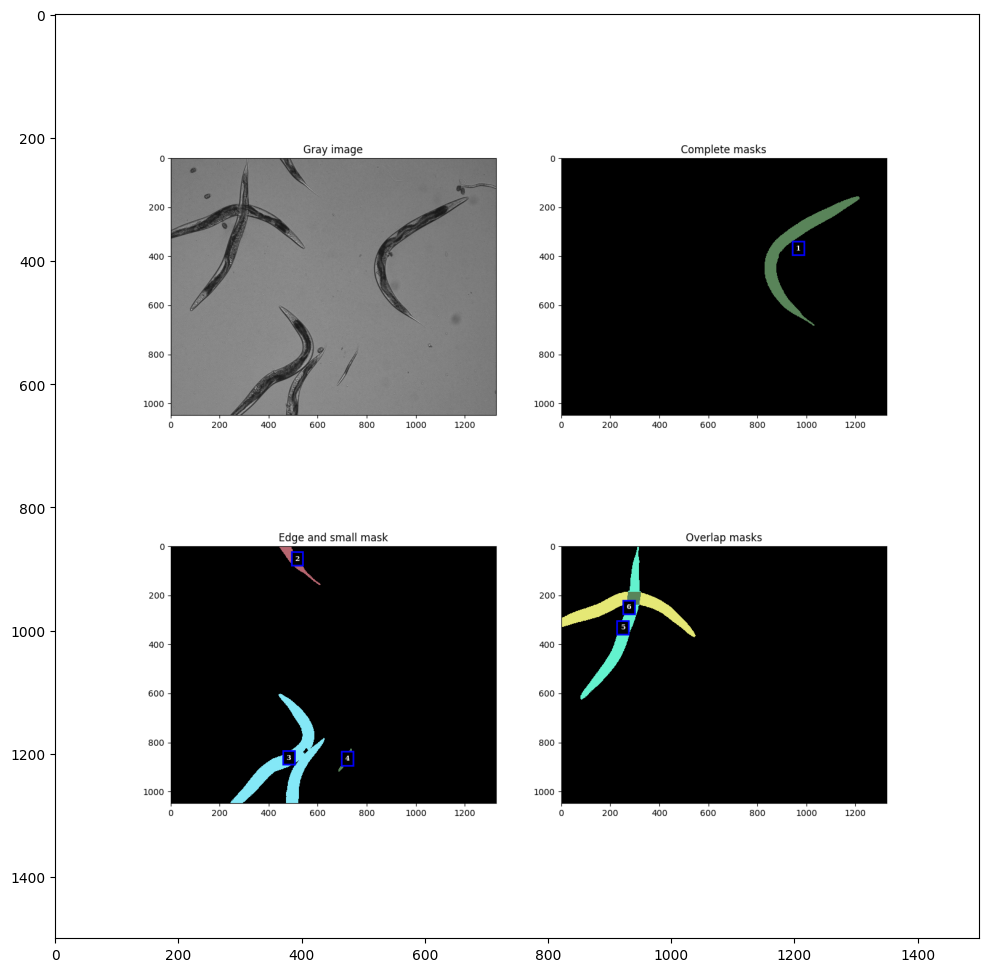

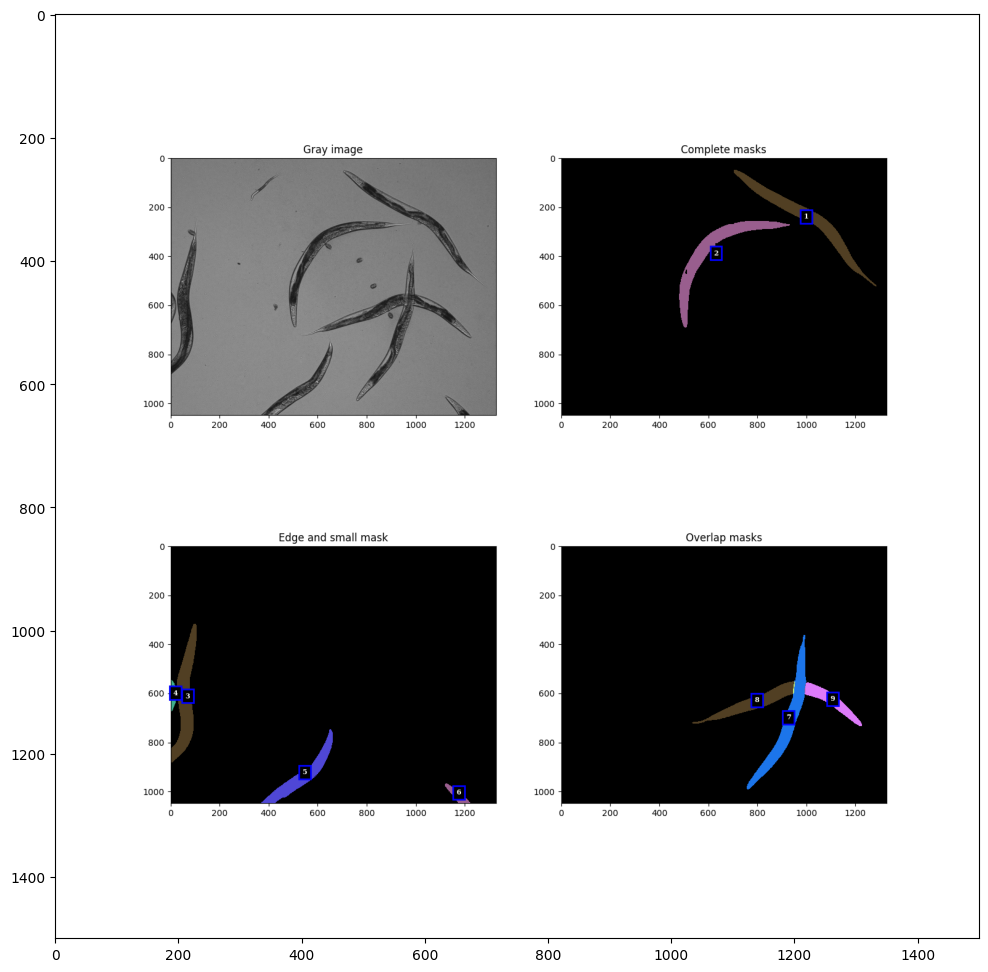

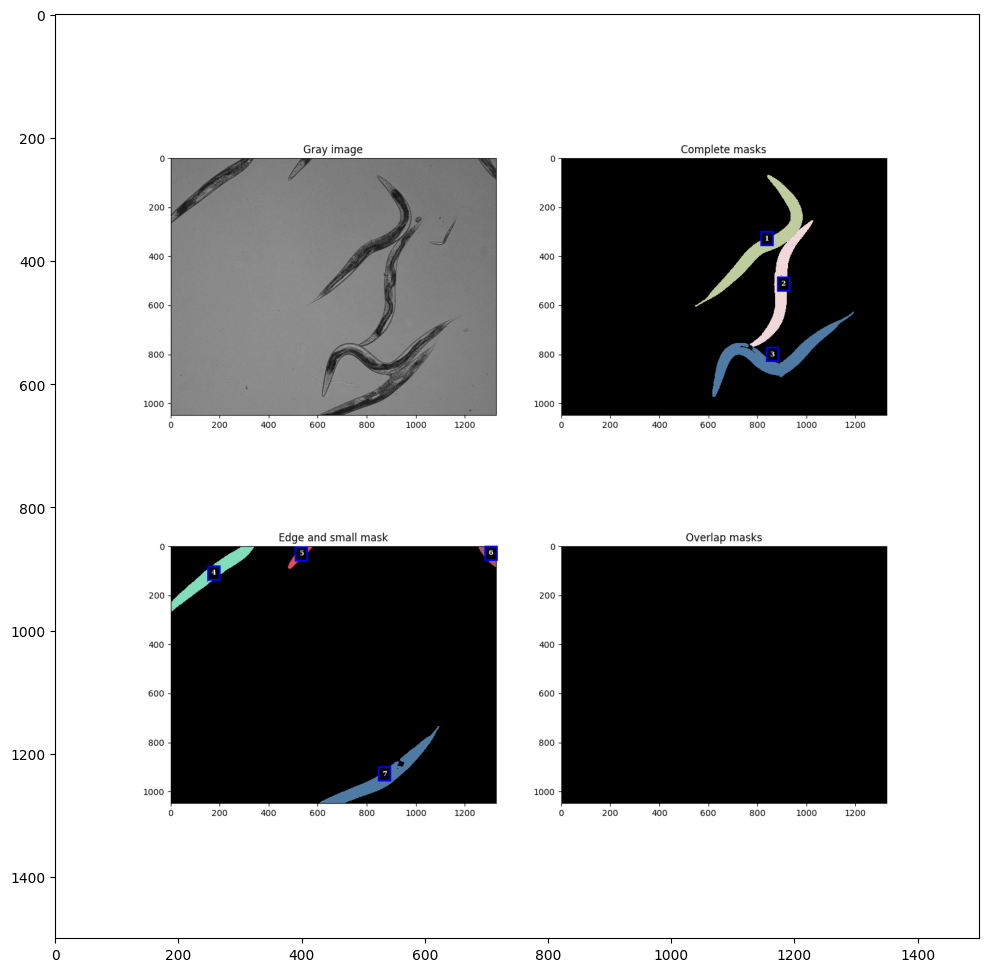

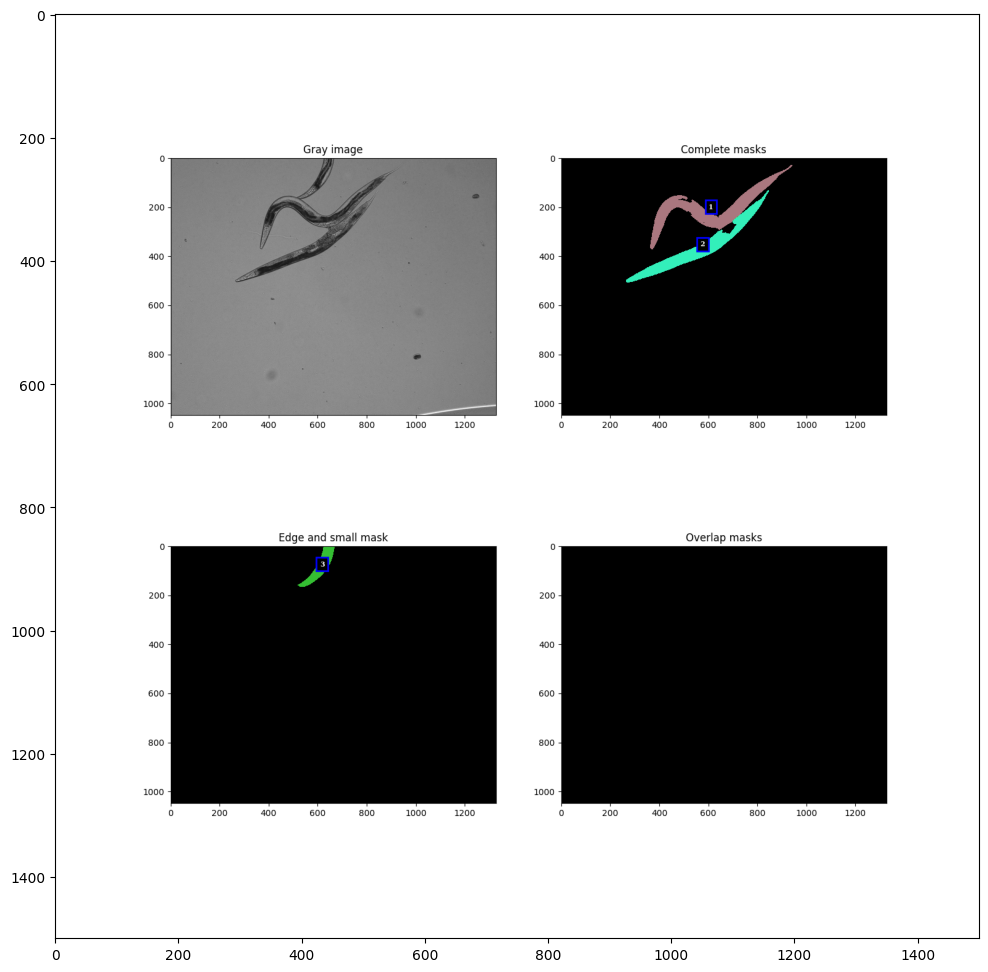

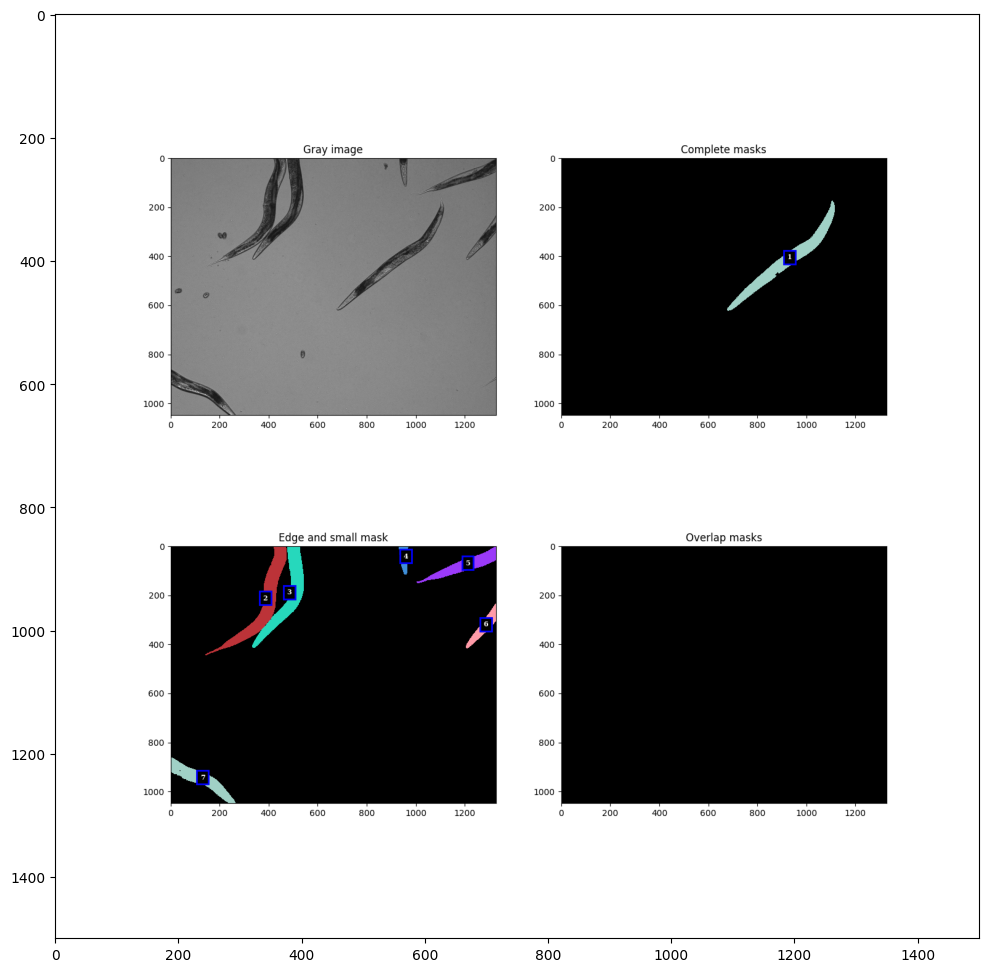

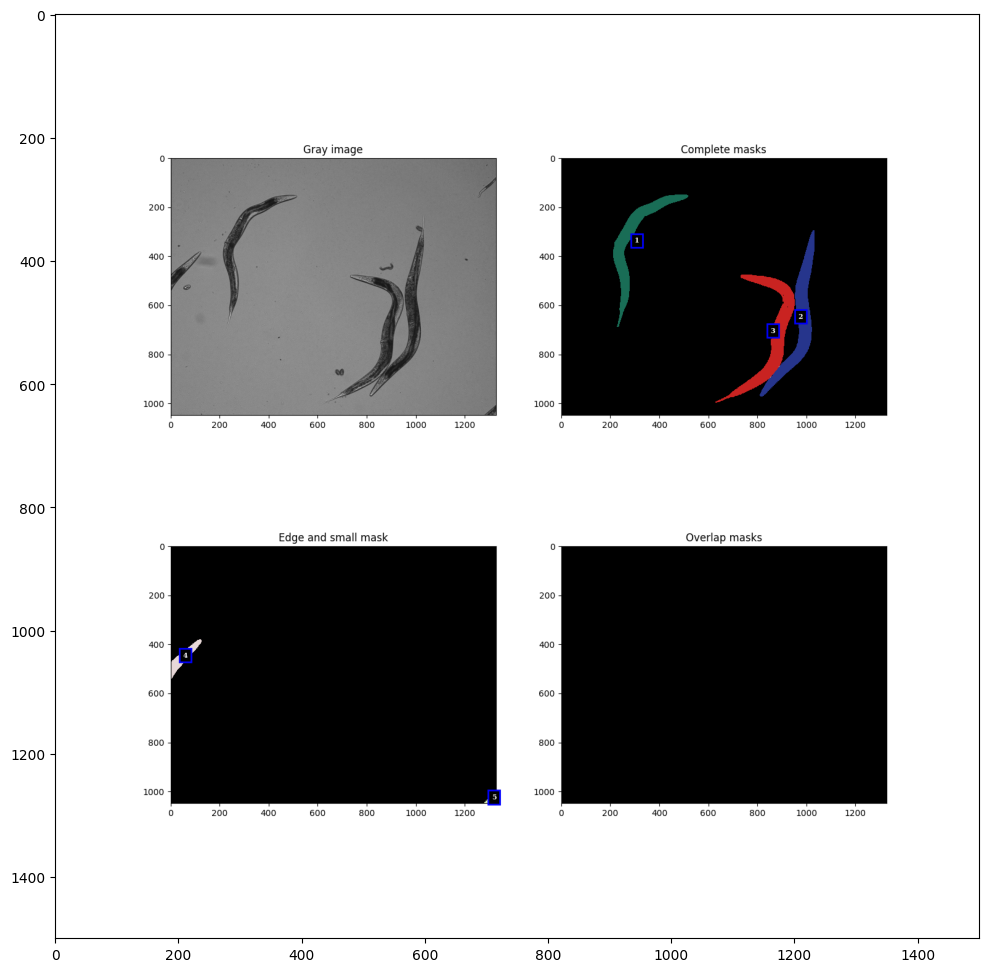

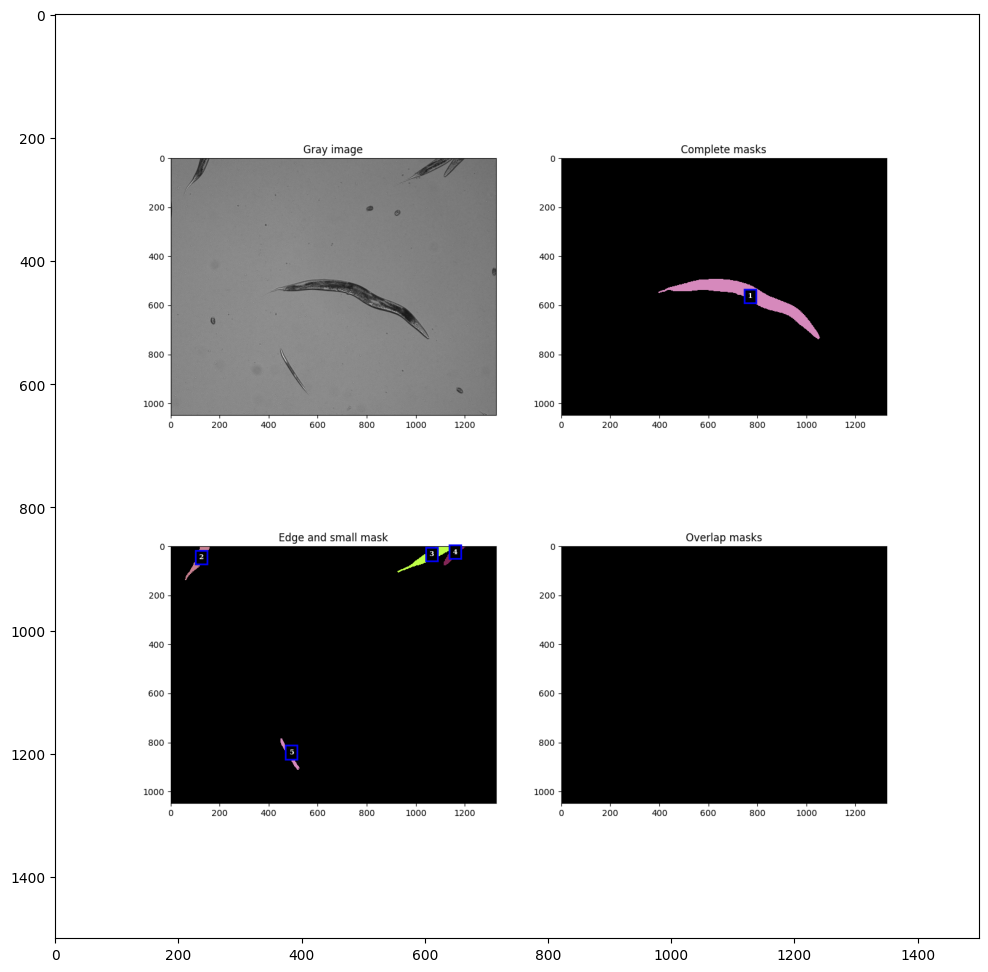

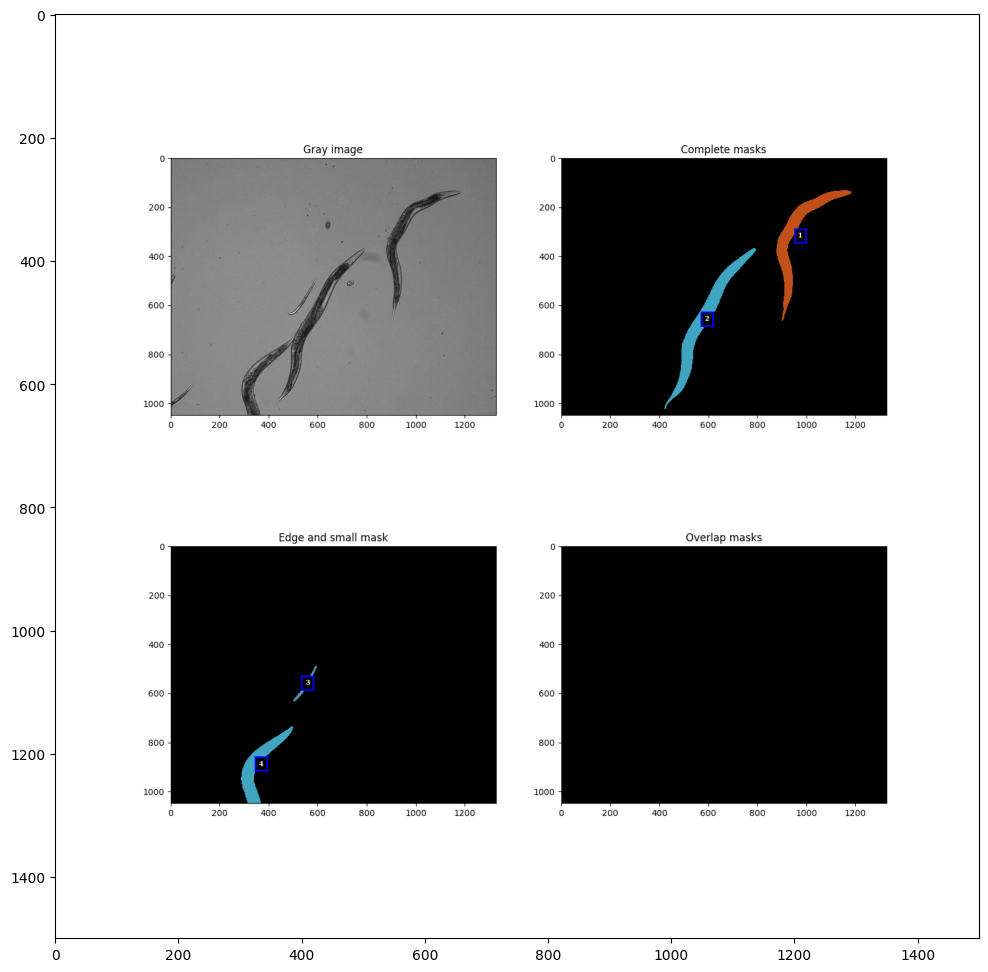

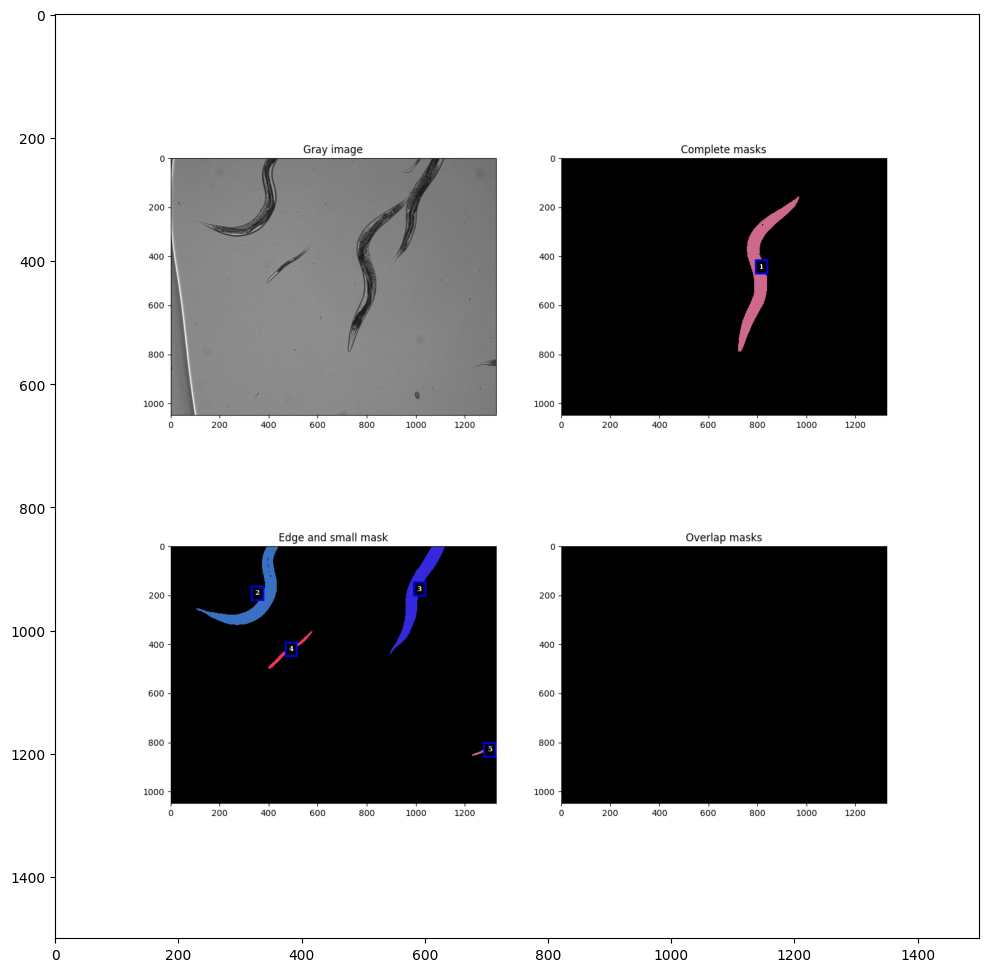

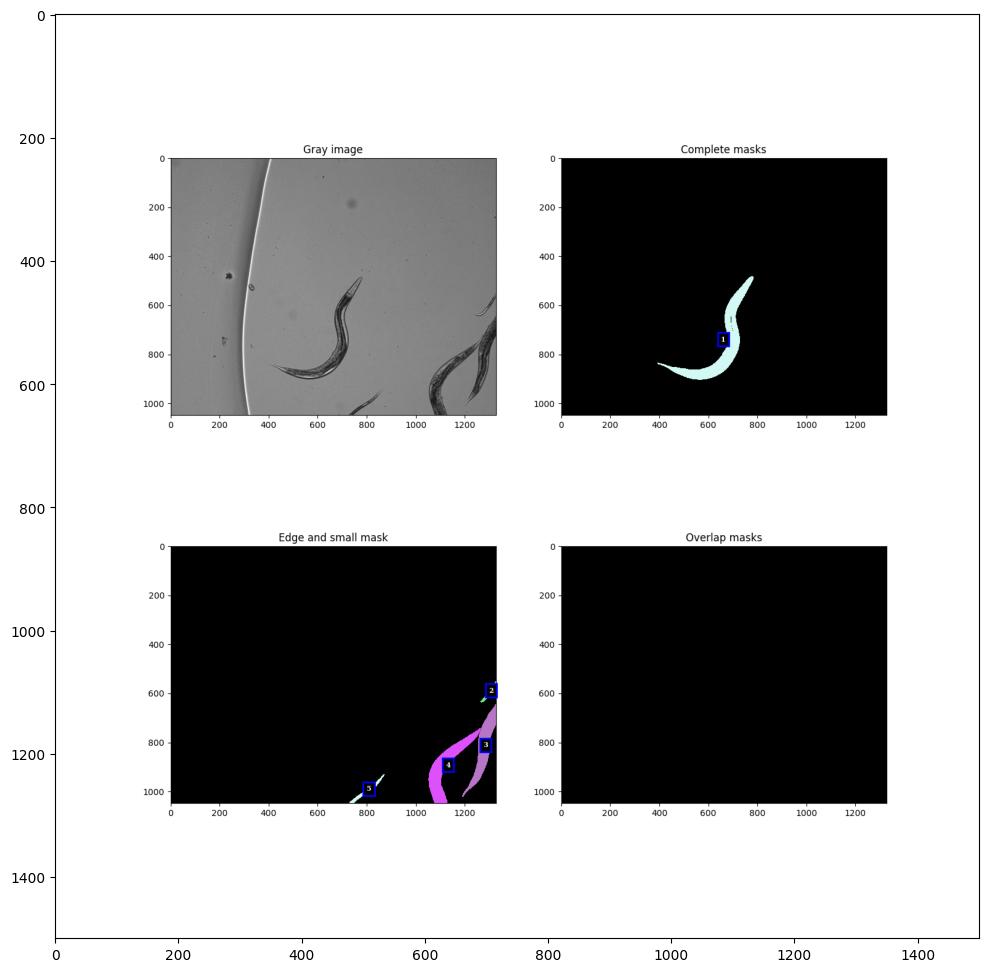

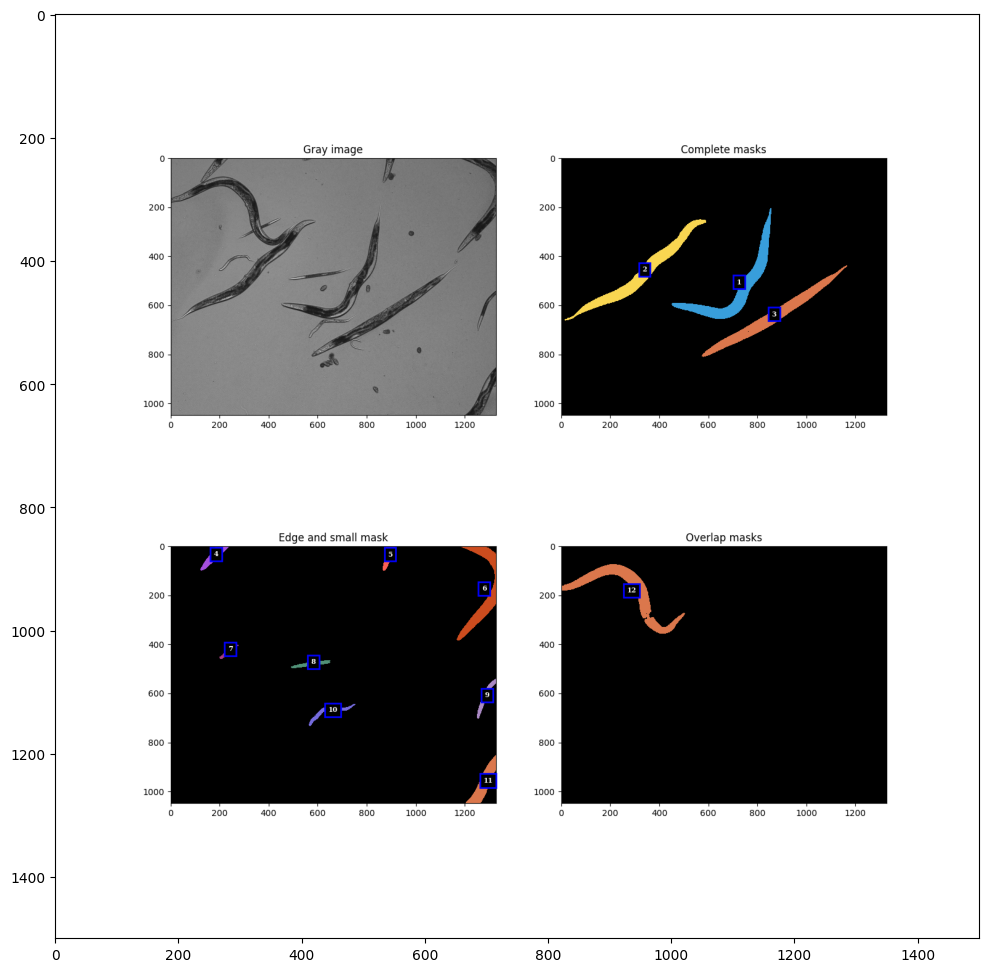

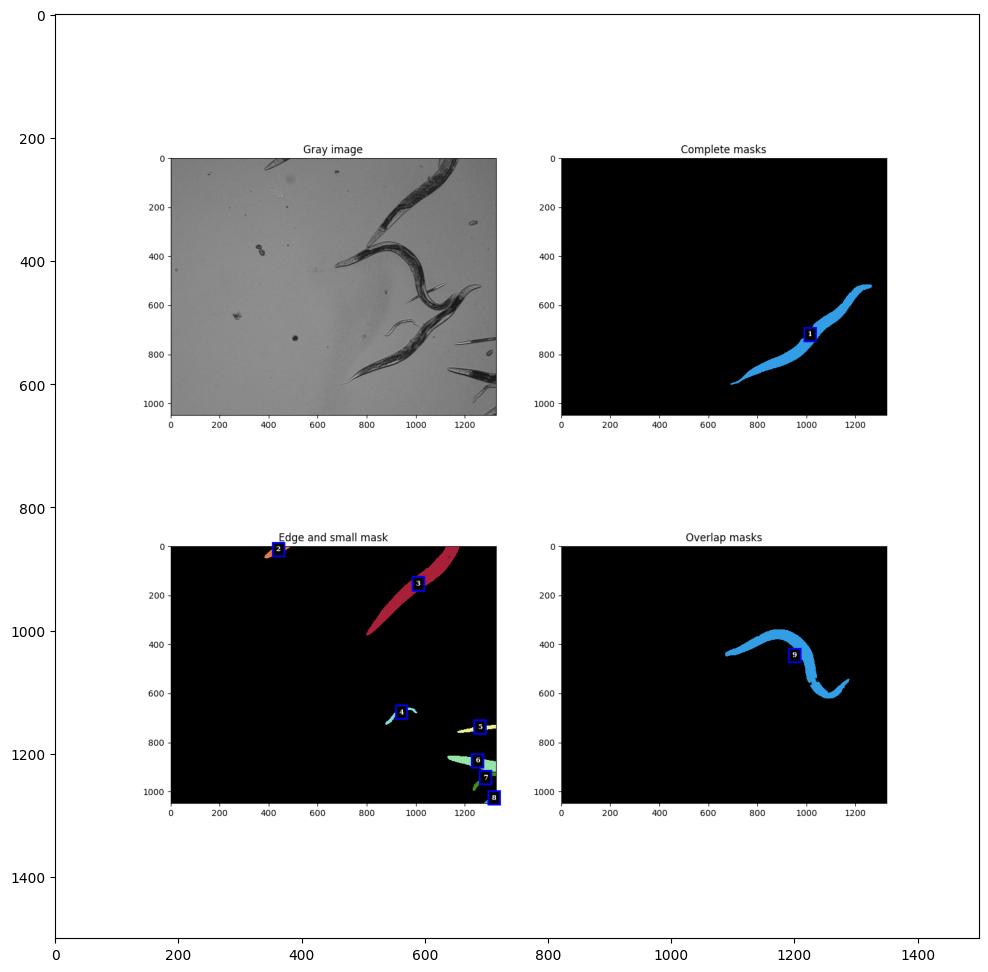

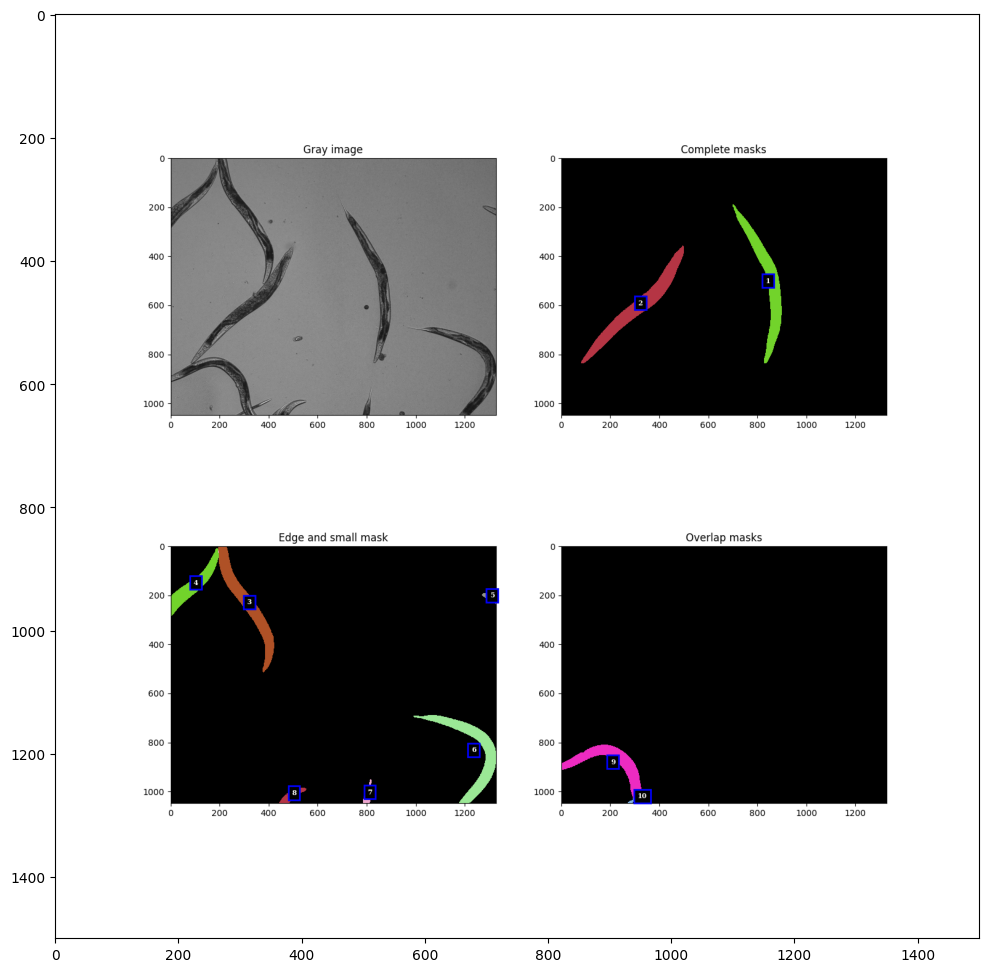

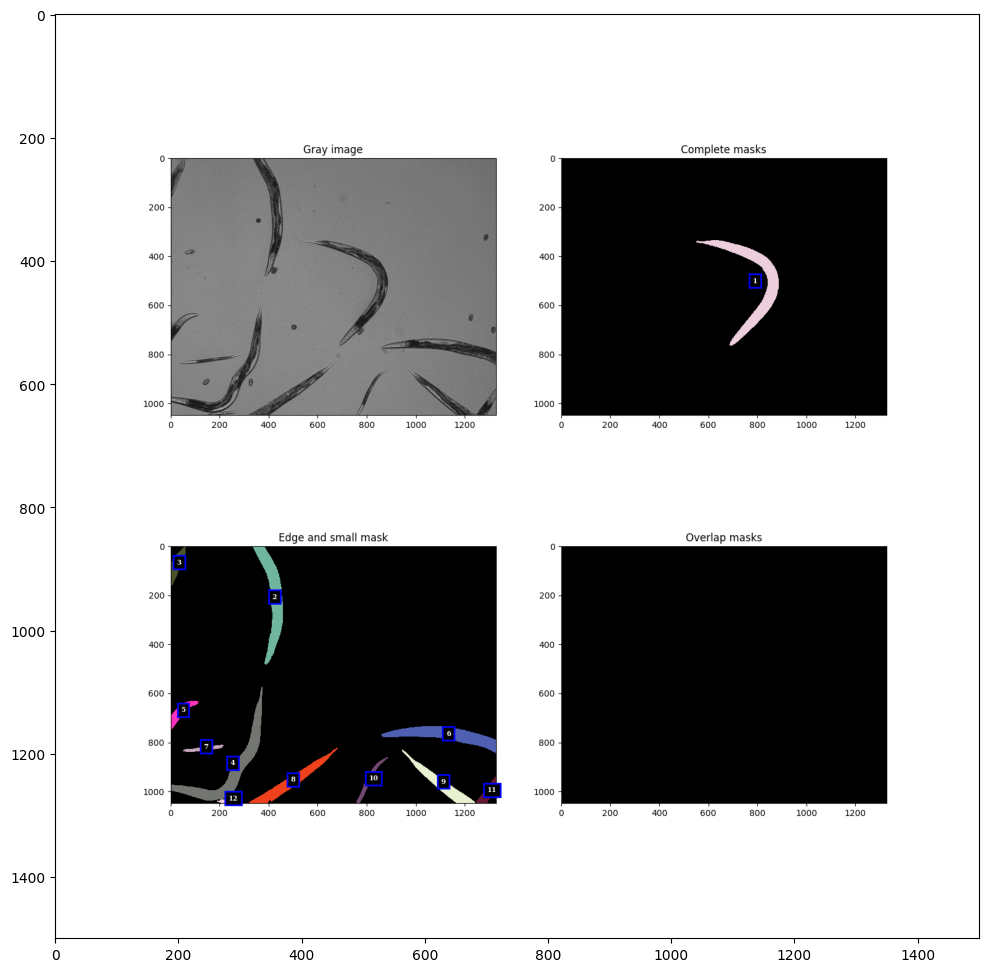

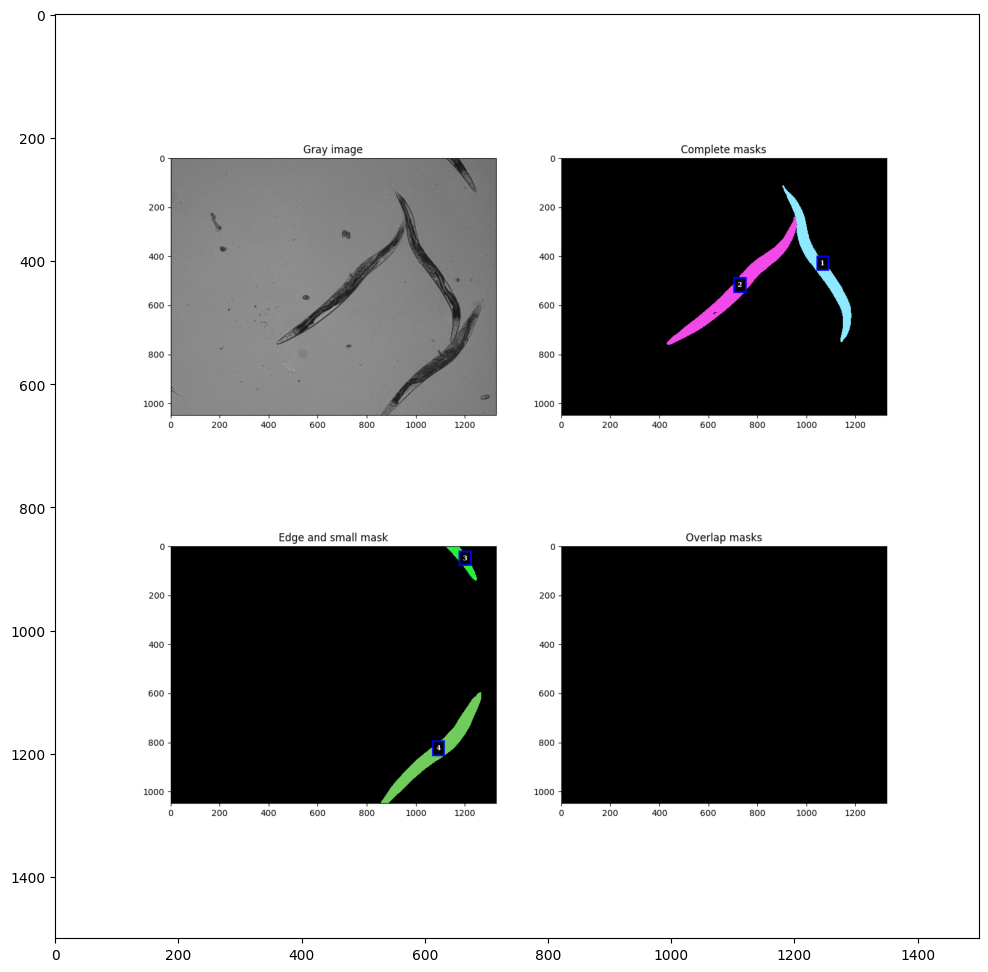

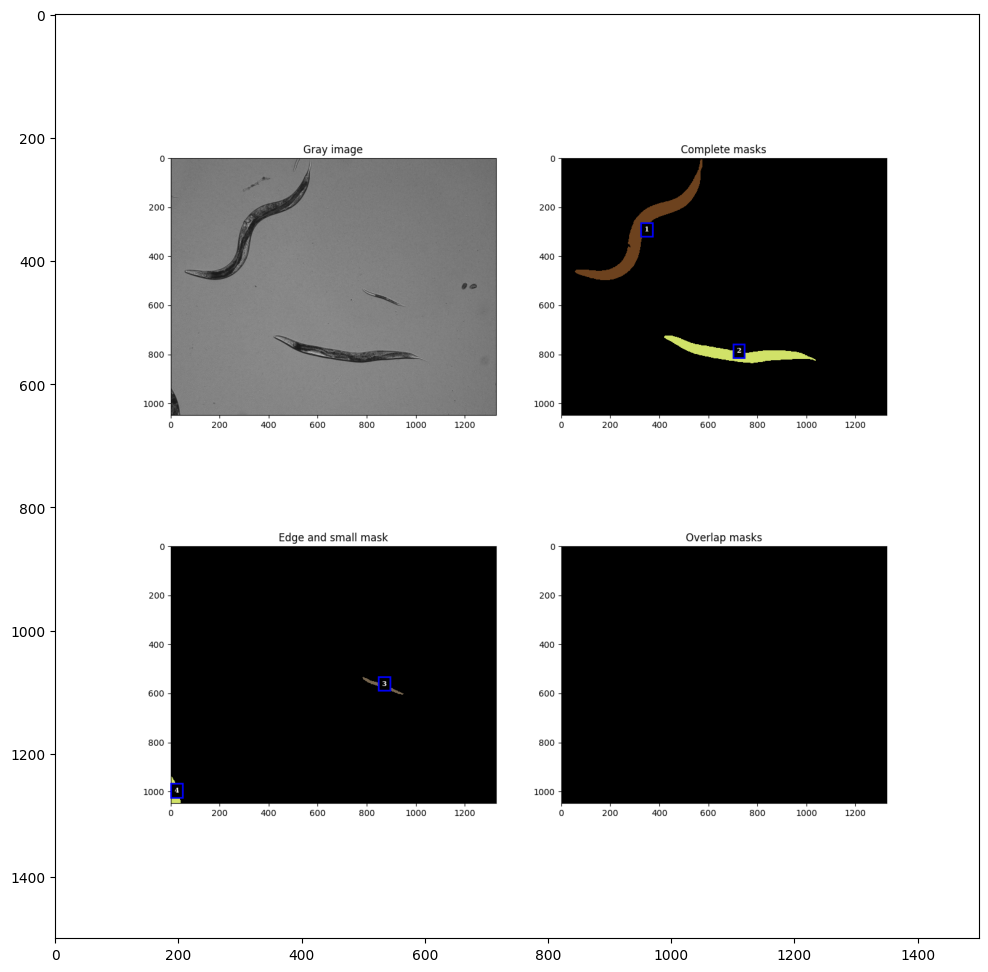

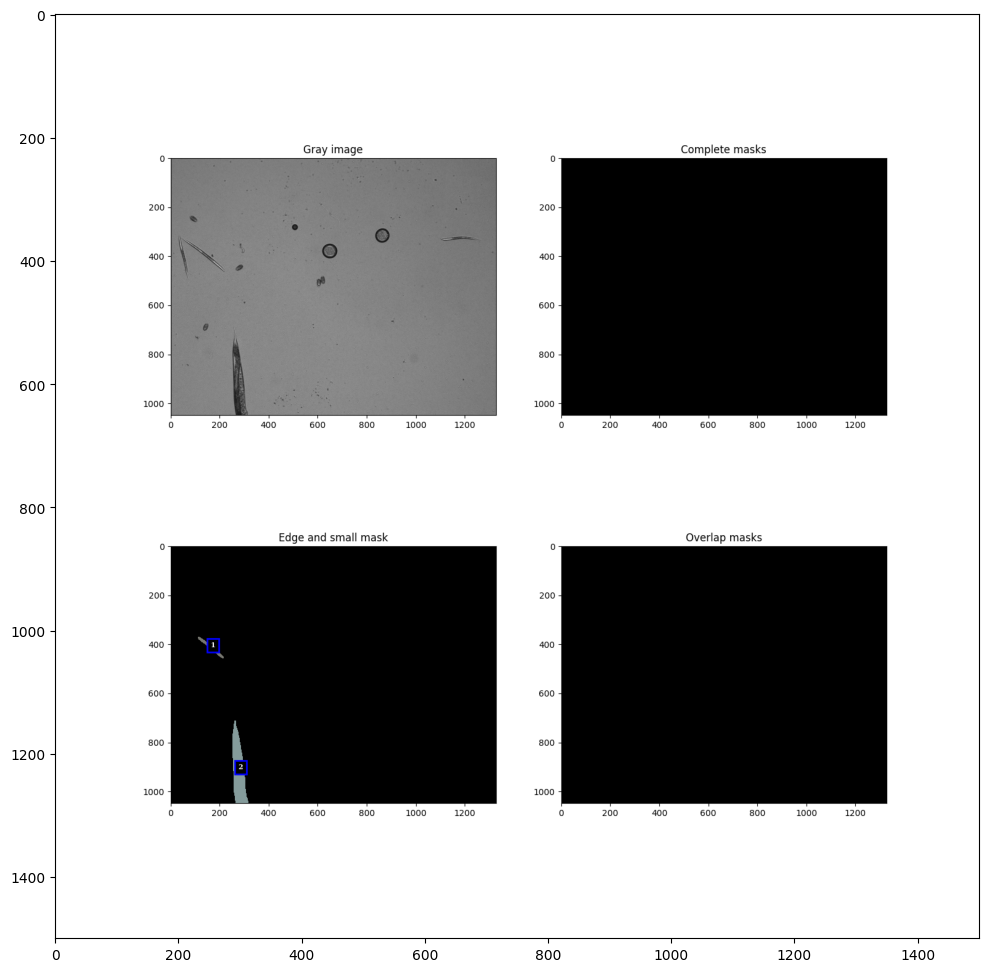

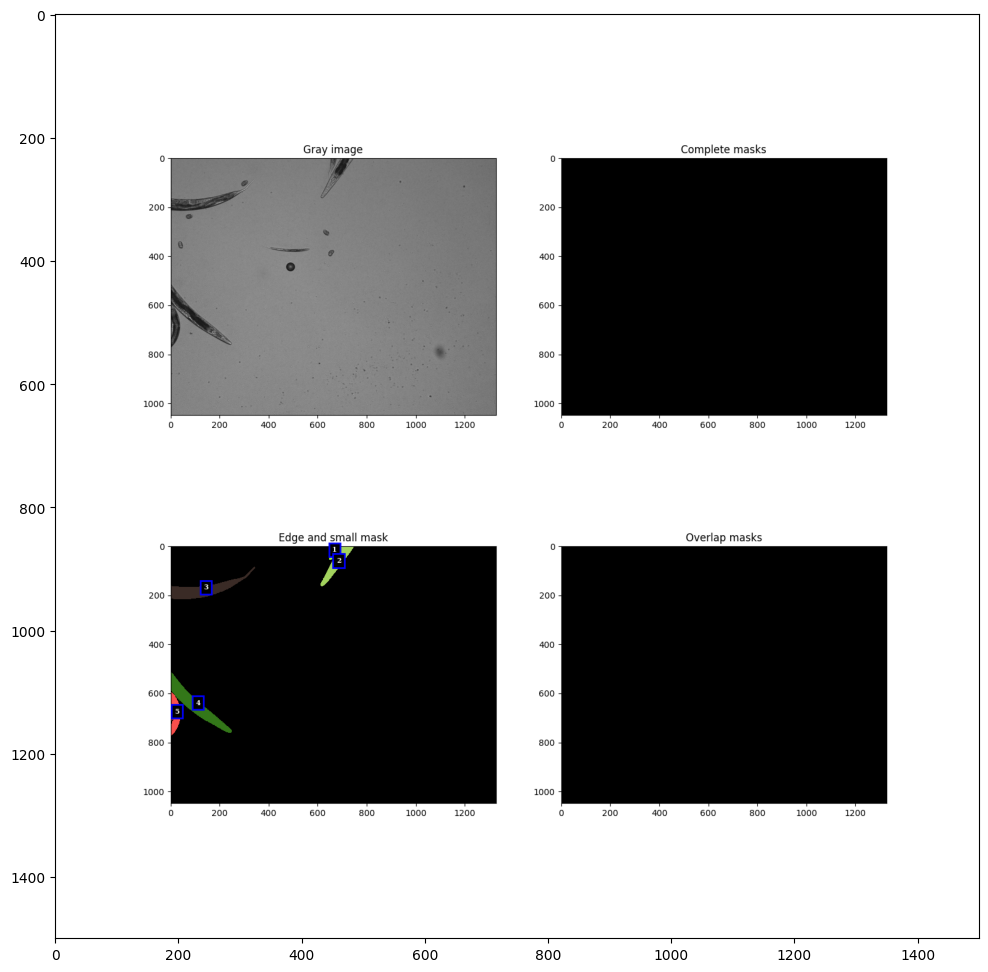

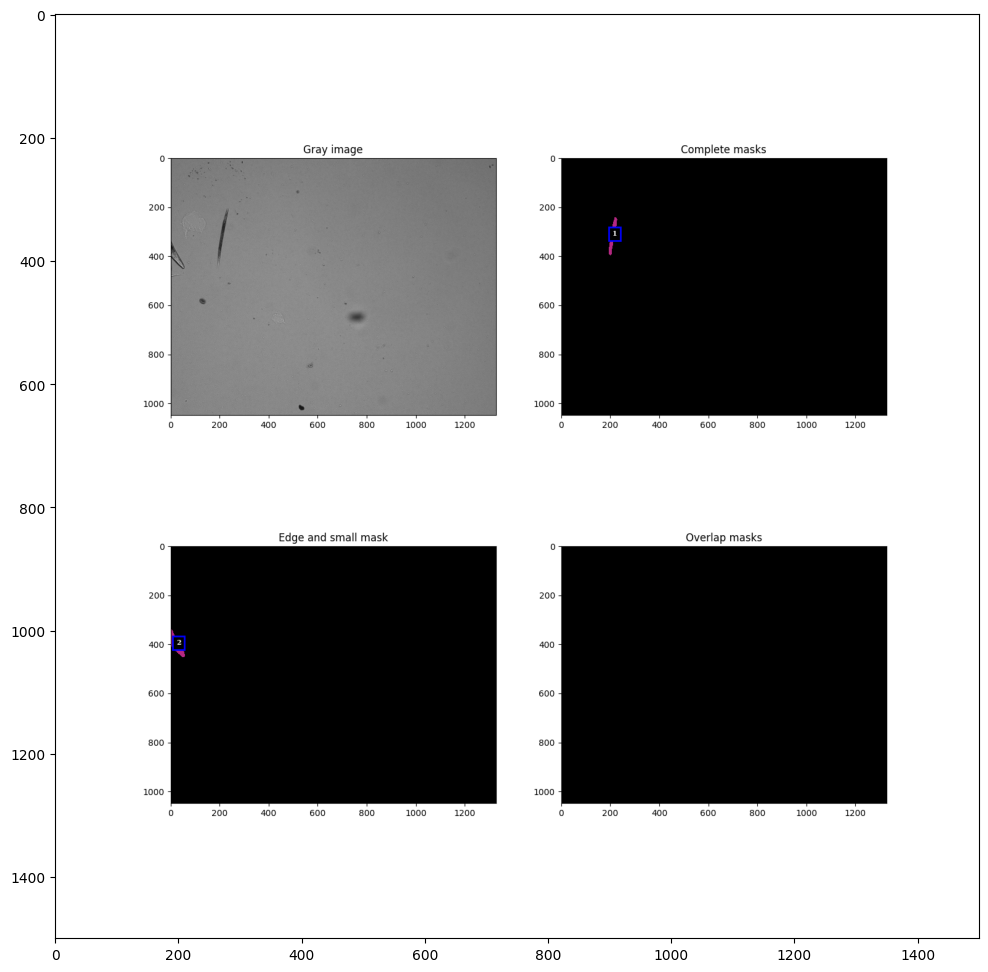

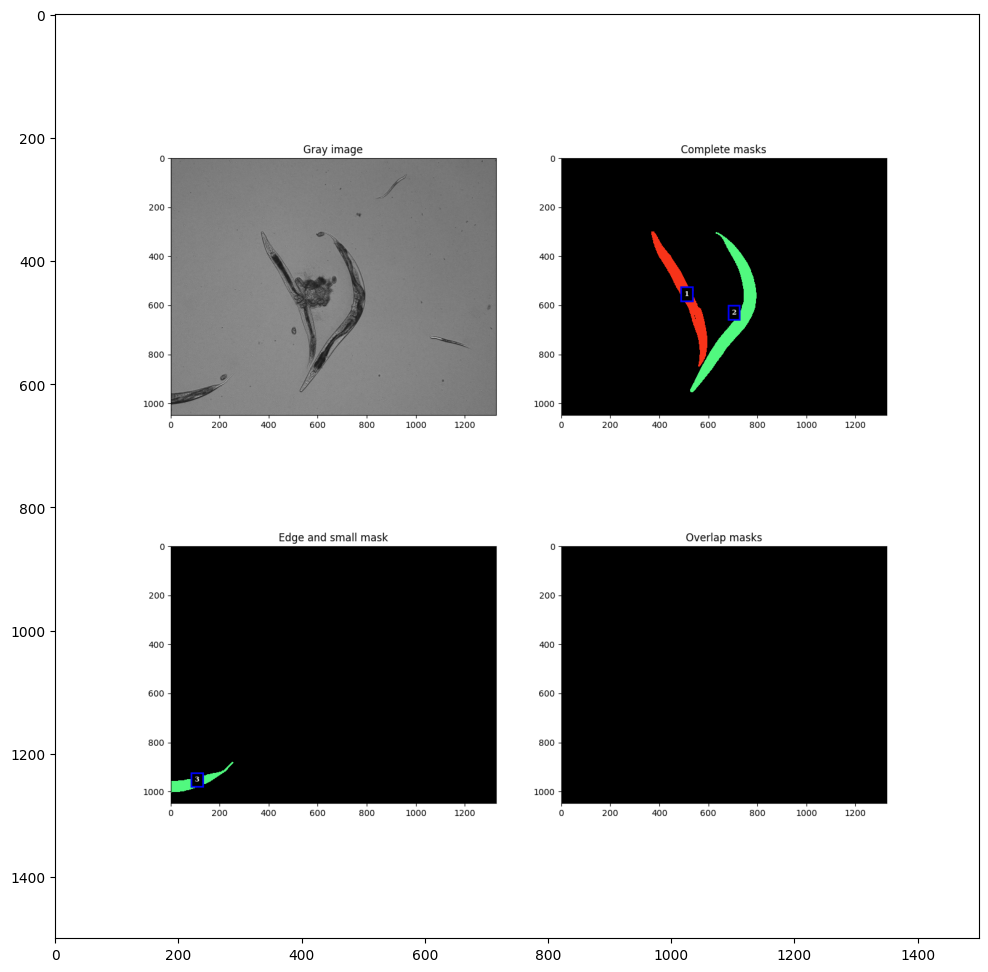

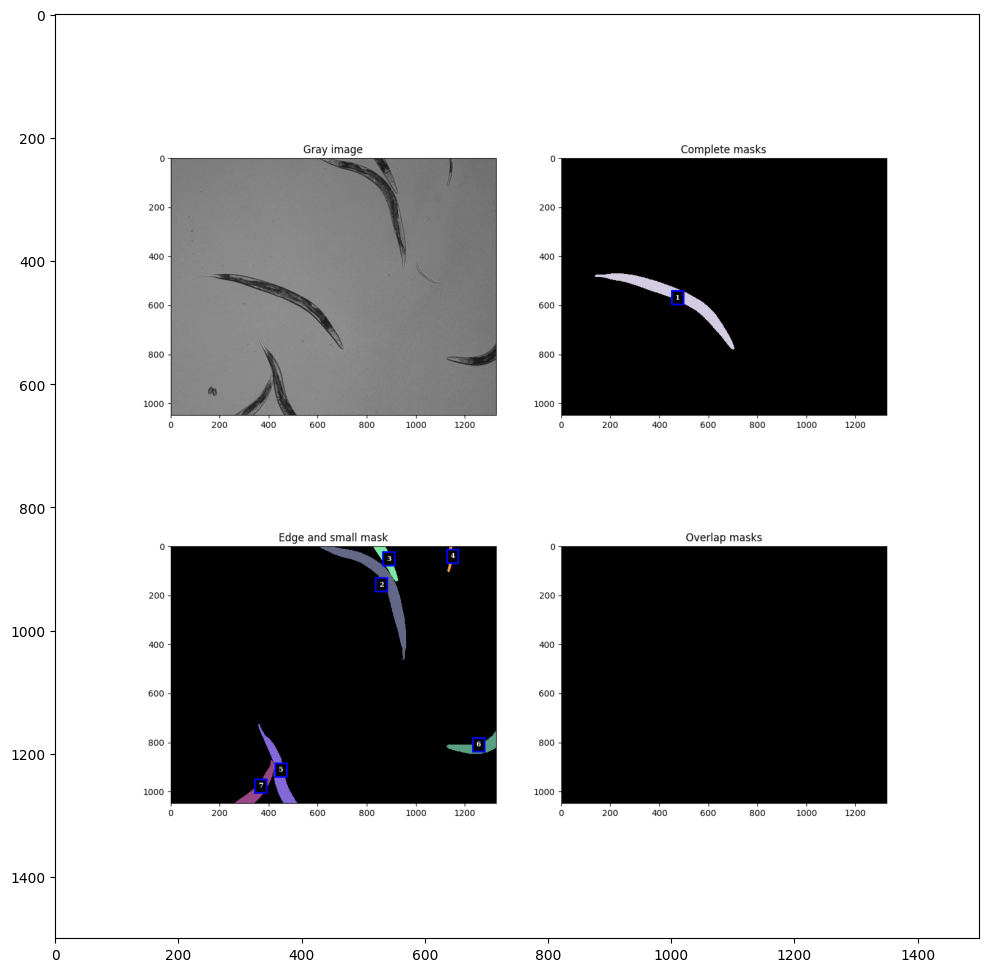

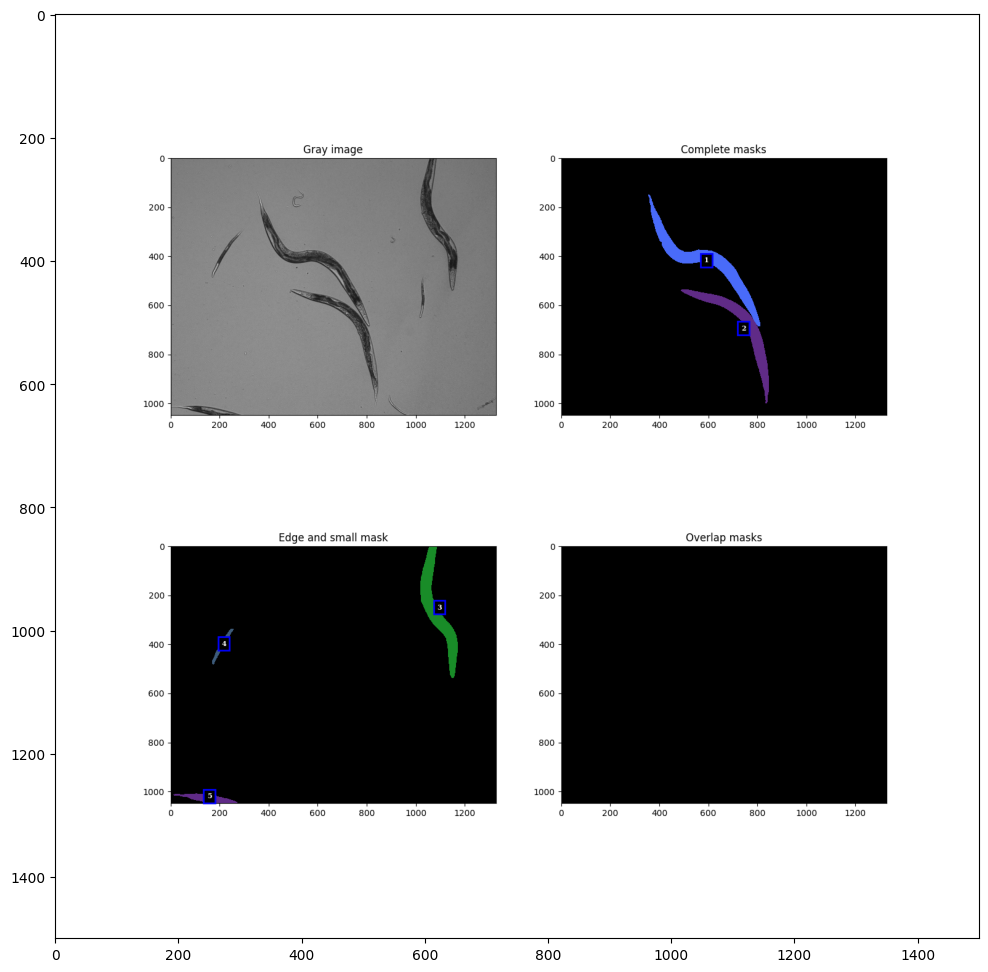

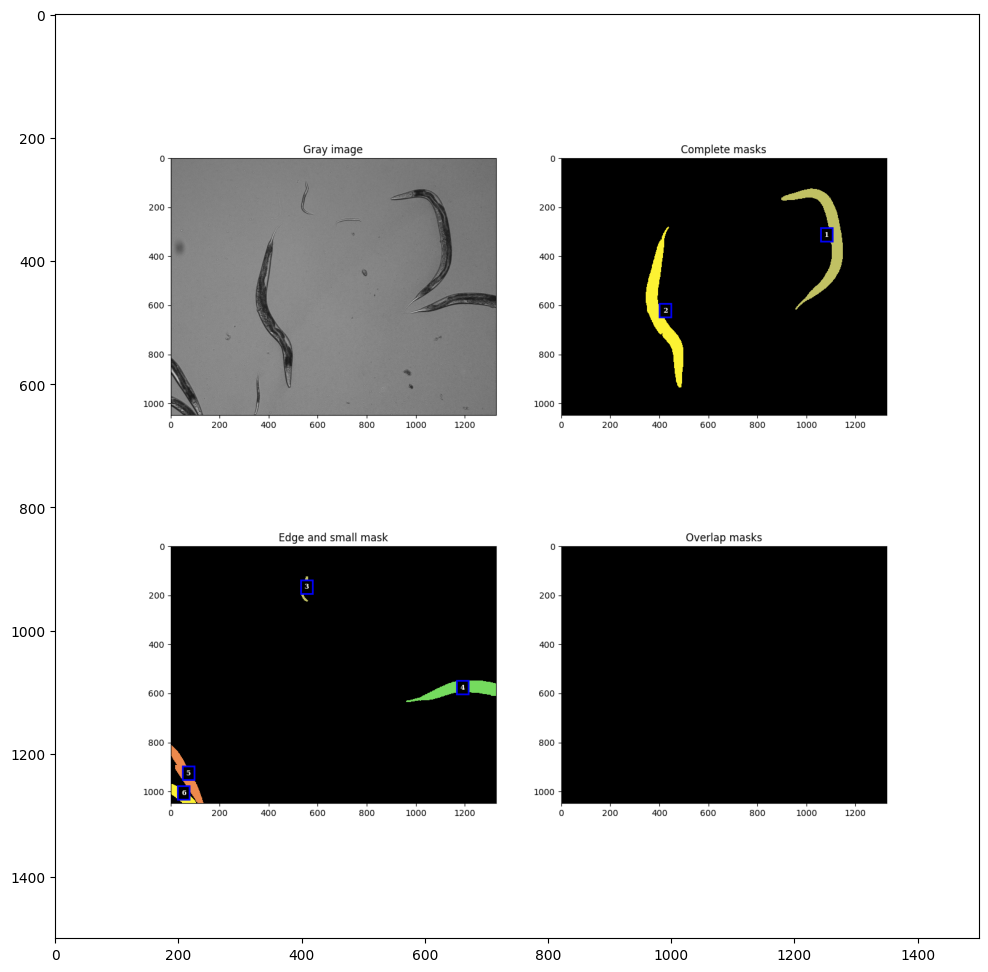

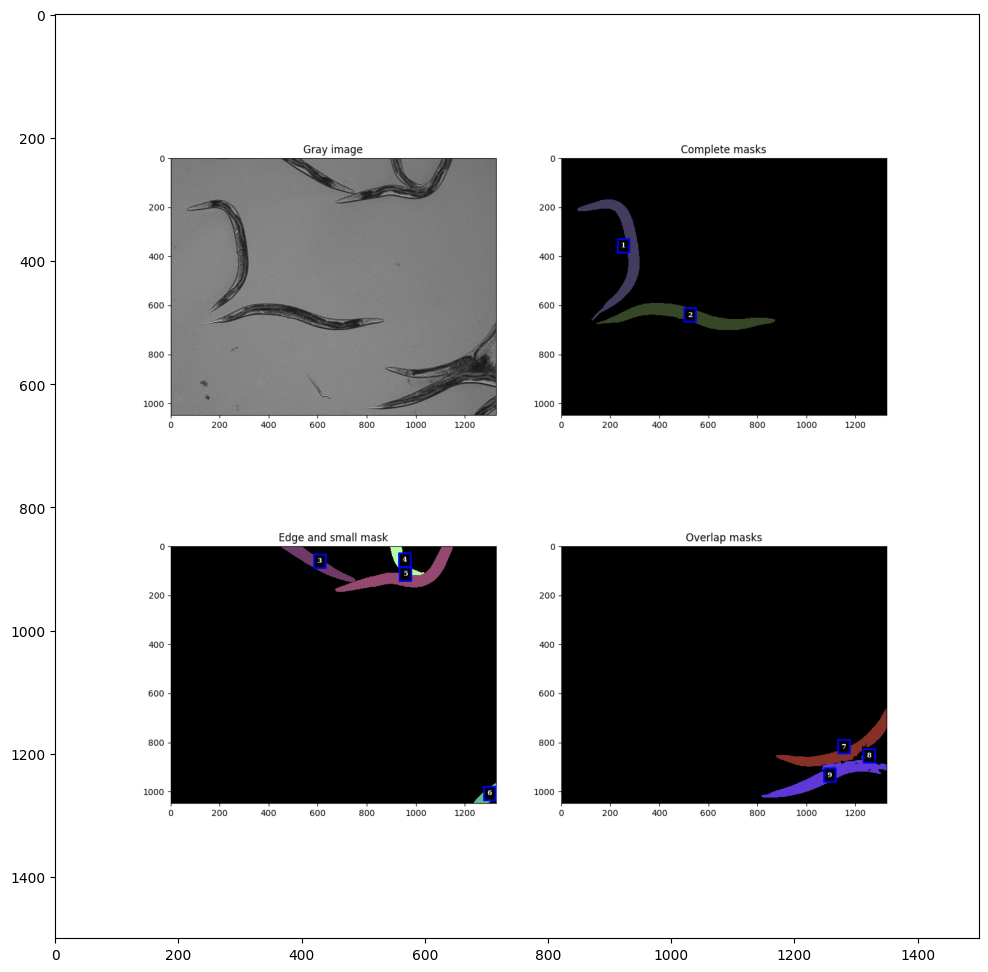

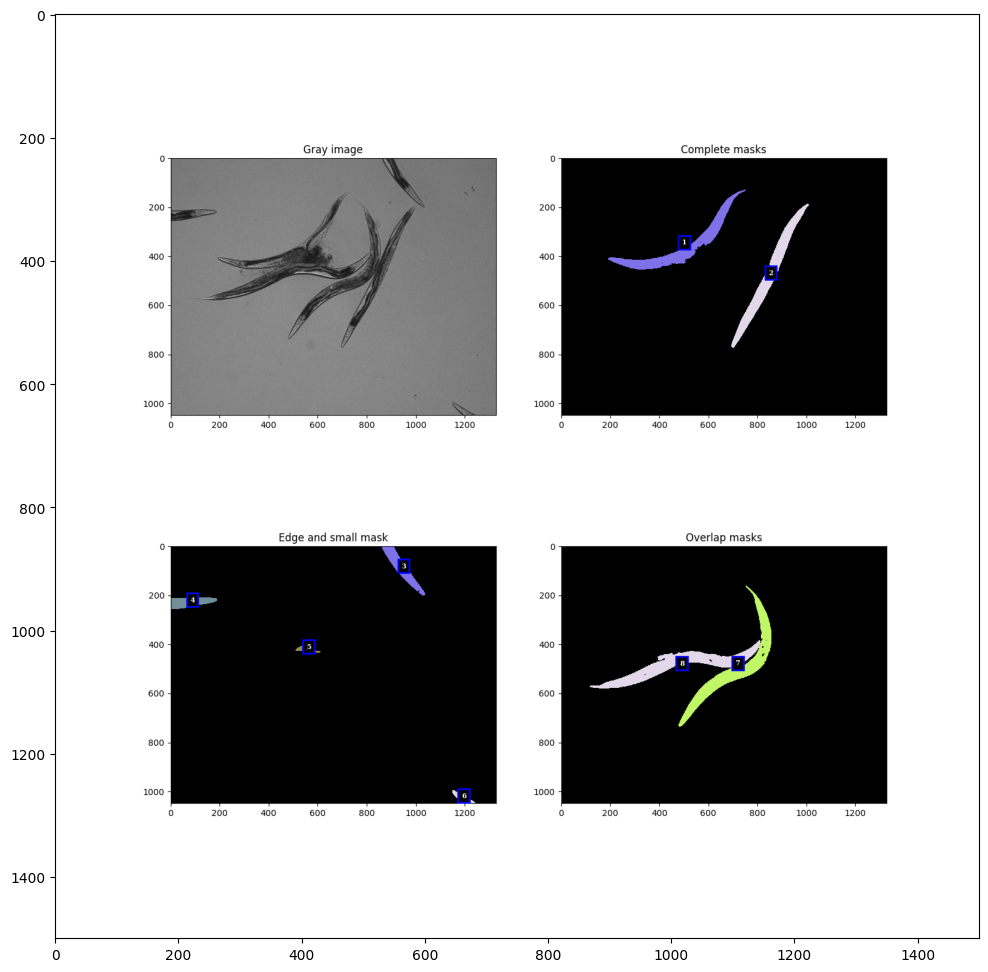

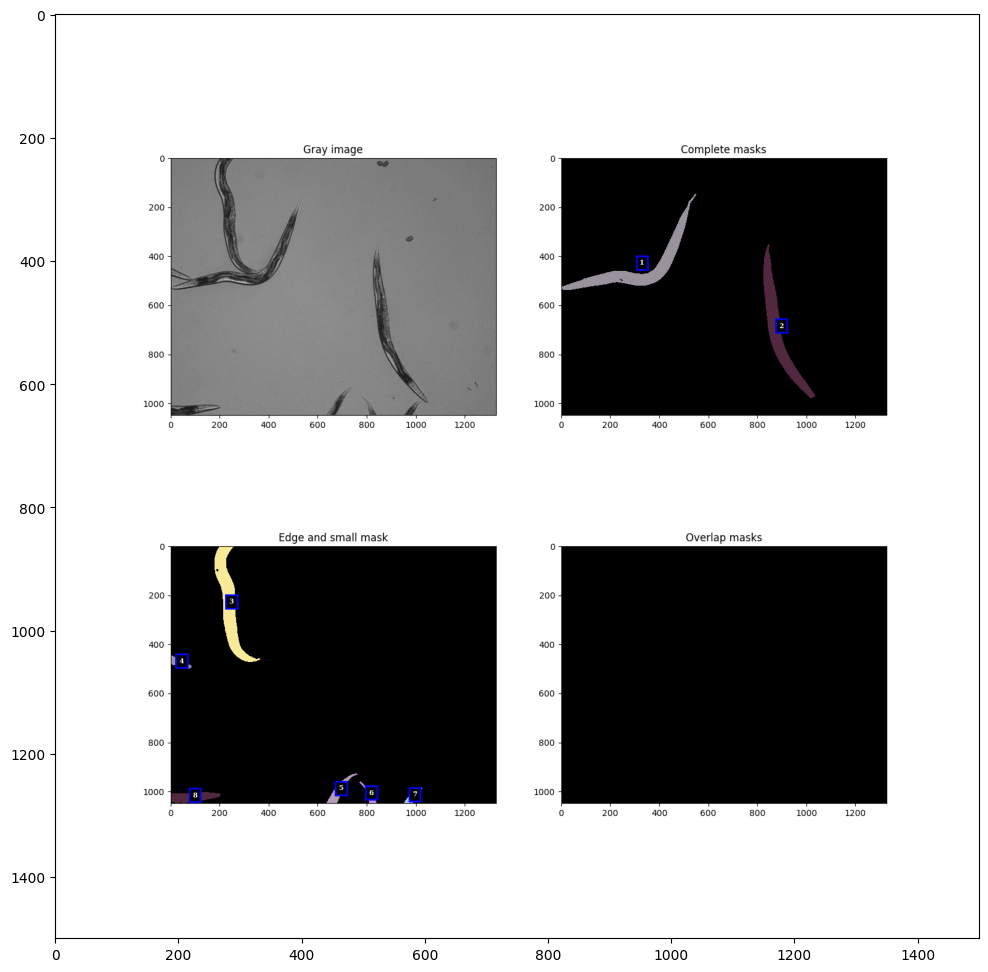

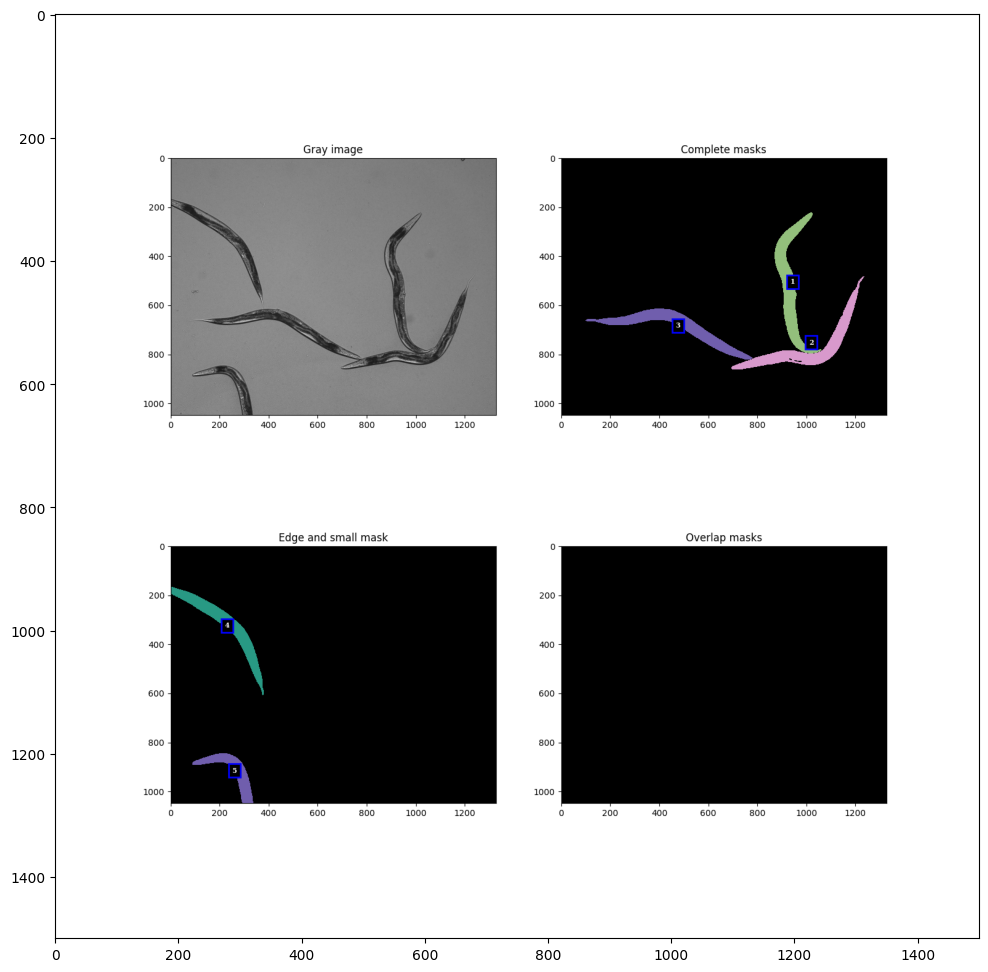

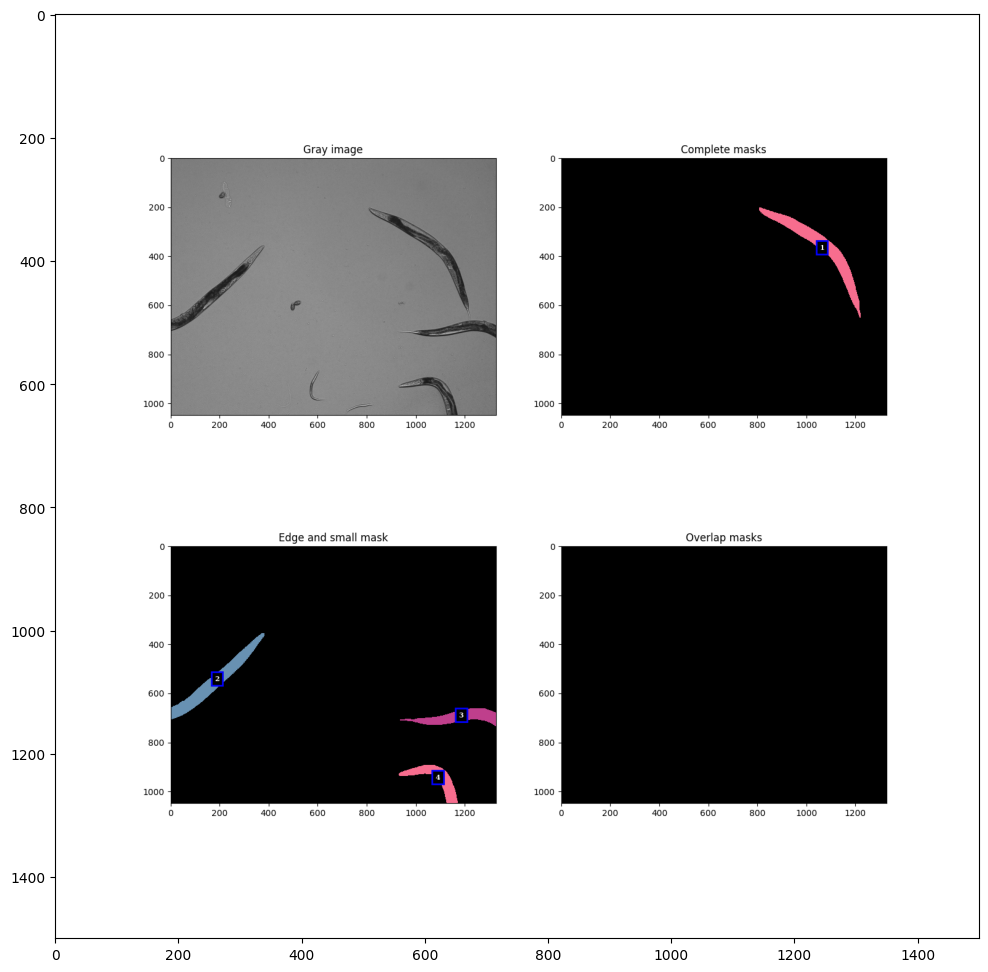

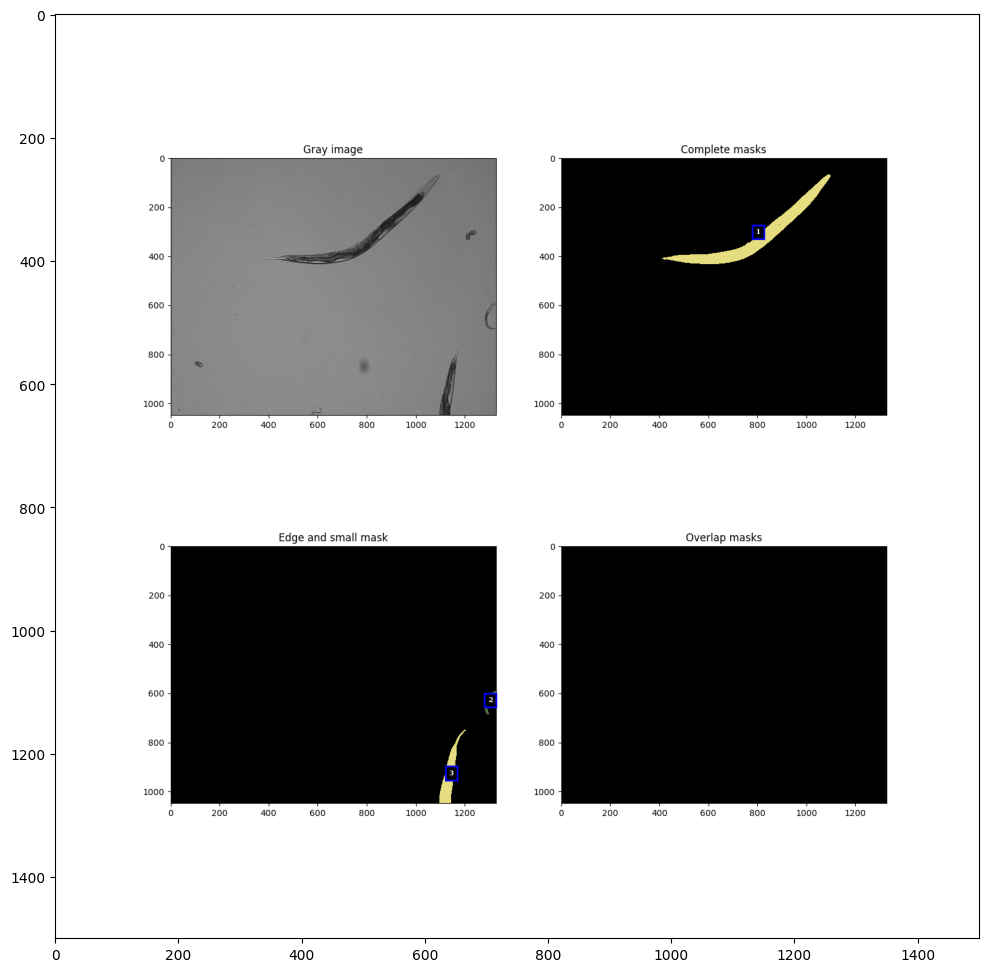

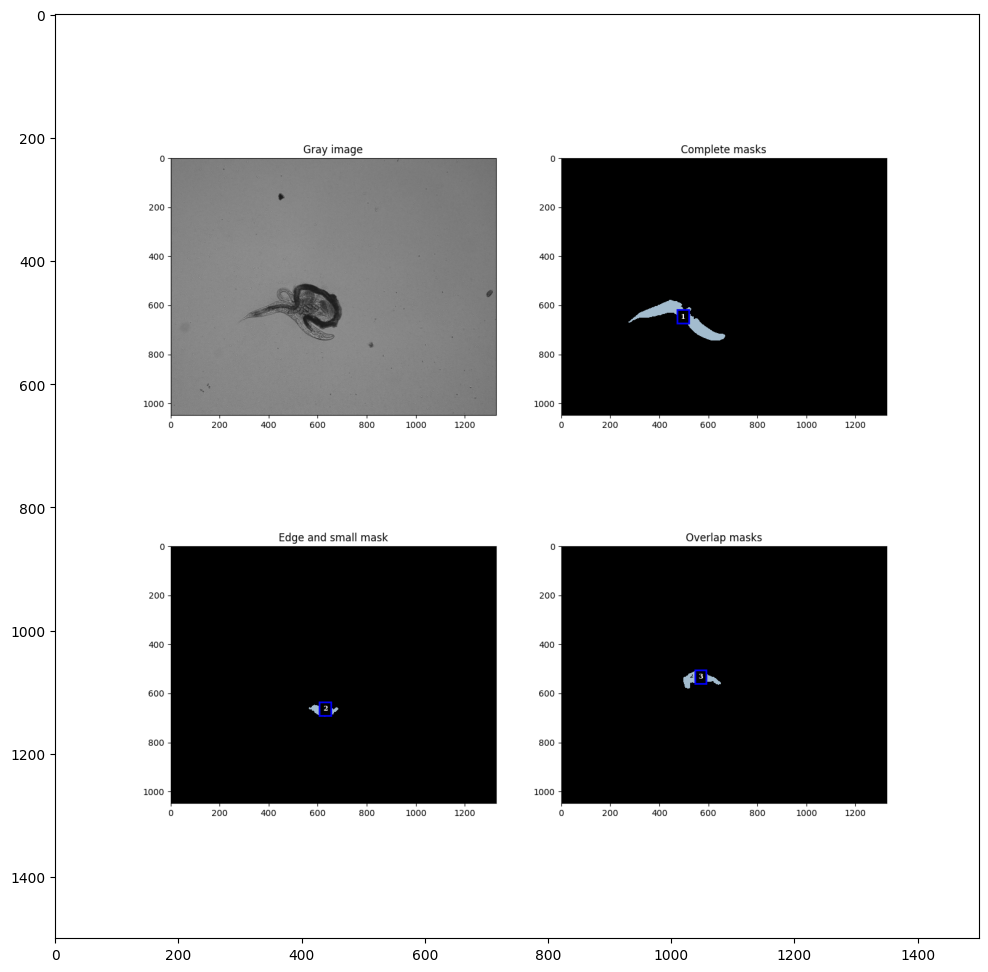

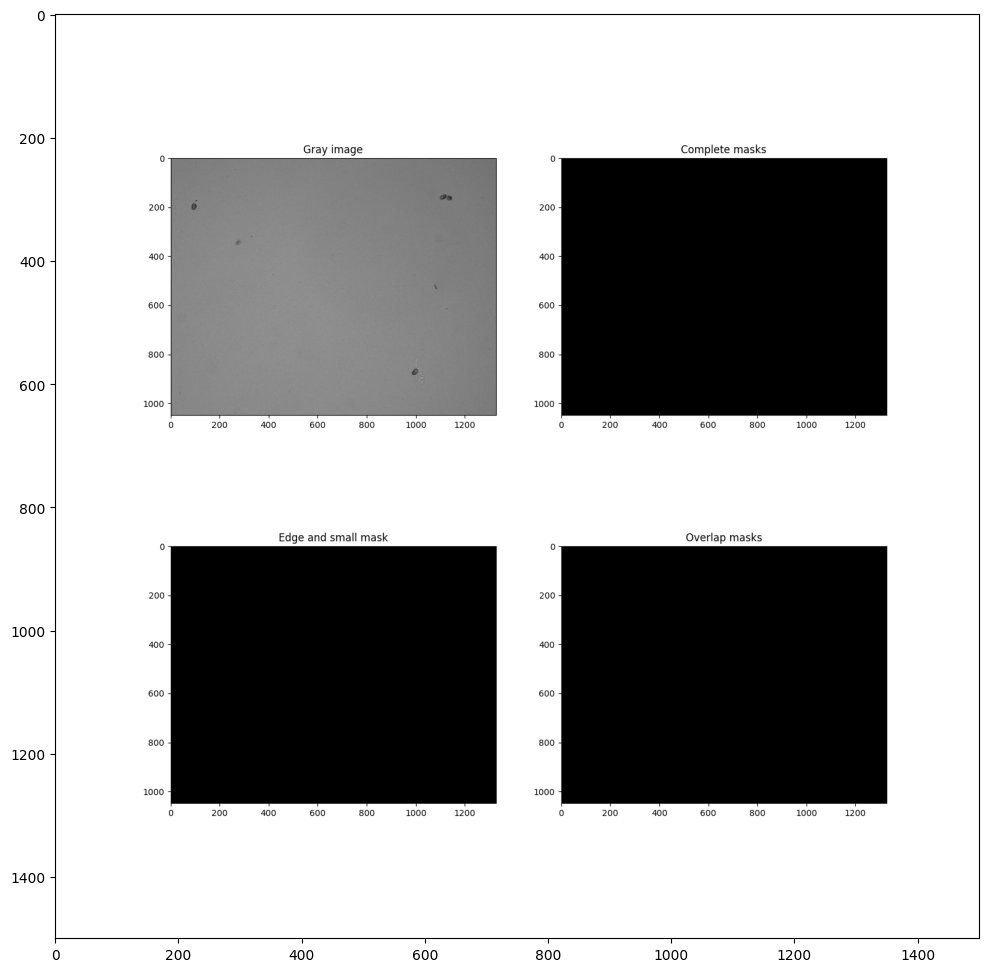

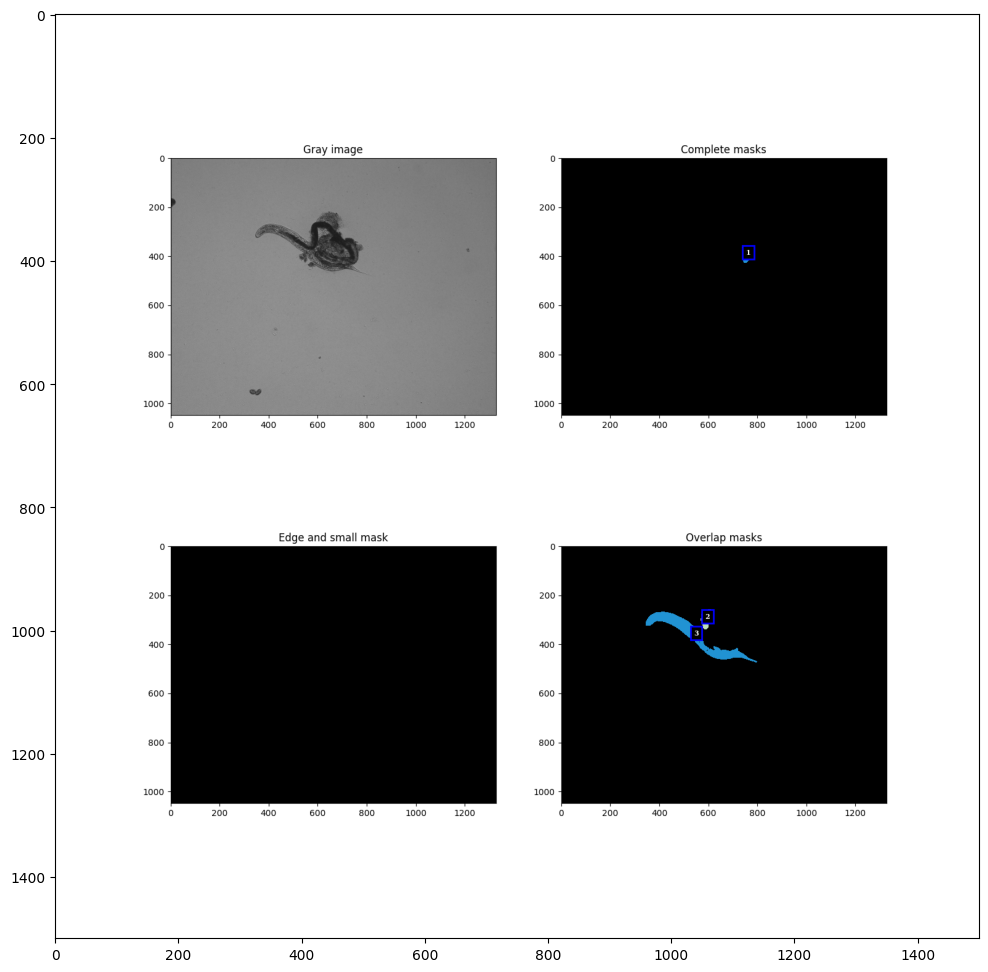

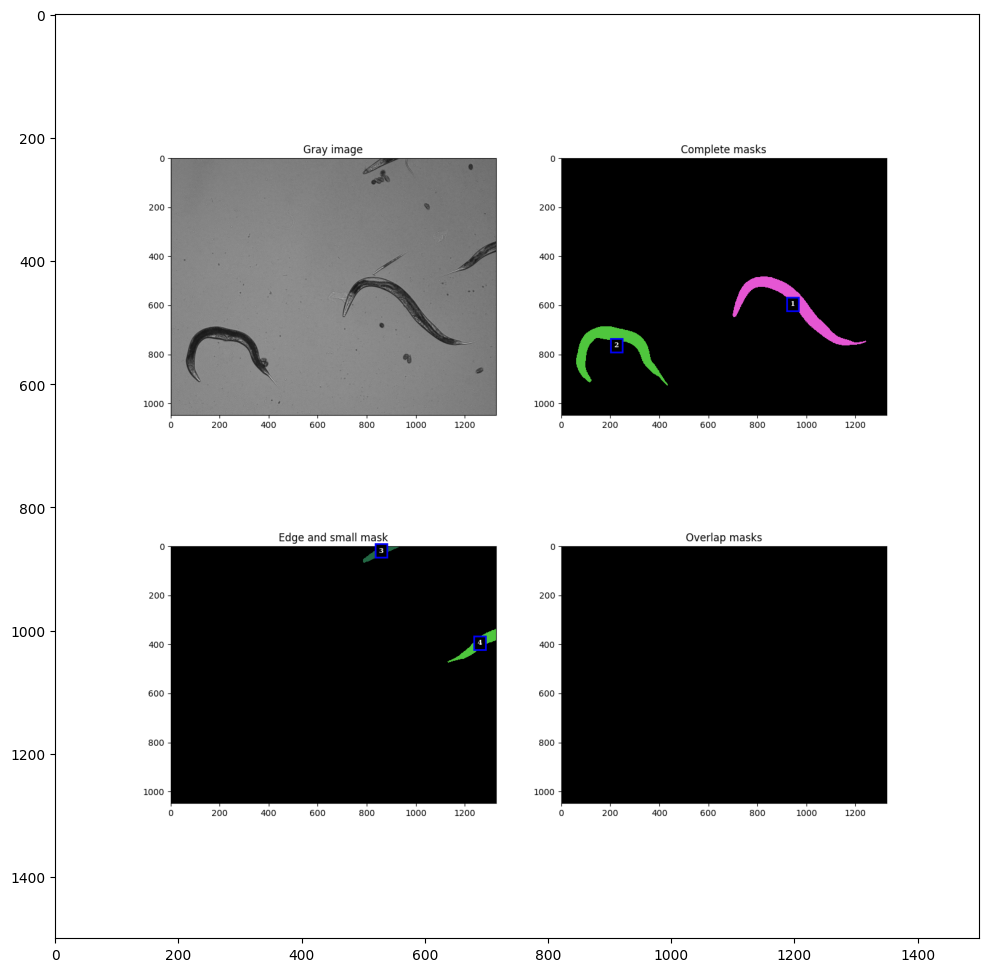

In [35]:
#@title **Begin post-processing**
#@markdown Check if you want to split into subprocesses.
Parallel_process = True #@param {type:"boolean"}

#@markdown Enter the number of subprocesses to split.
N_process = 4 #@param {type:"number"}

area_percentage = 60
area_min = 600
kernel_size = 3
angle_value = 20

#@markdown Enter the paths  where the images will be saved.
path_save = '0_RGB_results/' #@param {type:"string"}
path_complete_mask = '1_complete_mask/' #@param {type:"string"}
path_edge_small_mask = '1_edge_small_mask/' #@param {type:"string"}
path_overlap = '1_overlap/' #@param {type:"string"}

path_save = save_dir + path_save
path_complete_mask = save_dir + path_complete_mask
path_edge_small_mask = save_dir + path_edge_small_mask
path_overlap = save_dir + path_overlap

print('Folder complete mask:', path_complete_mask)
print('Folder edge and small mask:', path_edge_small_mask)
print('Folder overlap masks:', path_overlap)
print('Folder save_results:', path_save)

import numpy as np
from skimage import measure
from joblib import Parallel, delayed

args = {'Parallel_process': Parallel_process,
        'path_images': test_images,
        'path_SEGMENTATION': path_SEGMENTATION,
        'path_SKELETON': path_SKELETON,
        'path_complete_mask': path_complete_mask,
        'path_edge_small_mask': path_edge_small_mask,
        'path_overlap': path_overlap,
        'path_save': path_save,
        'area_percentage': area_percentage,
        'area_min': area_min,
        'kernel_size': kernel_size,
        'angle_value': angle_value
        }

def post_processing(args, name_image):
    name_image_ = name_image.split('.')[0]
    name_image_save = name_image_ + '.bmp'
    image_seg = cv2.imread(args['path_SEGMENTATION'] + name_image_save)

    if not os.path.exists(args['path_save'] + name_image_ + '.png'):
        image_skl = cv2.imread(args['path_SKELETON'] + name_image_save)
        image_skl = (cv2.cvtColor(image_skl, cv2.COLOR_BGR2GRAY) > 0) * 255

        area_min = args['area_min']
        angle_value = args['angle_value']
        kernel_size = args['kernel_size']
        area_percentage = args['area_percentage']

        path_images = args['path_images']
        path_complete_mask = args['path_complete_mask']
        path_edge_small_mask = args['path_edge_small_mask']
        path_overlap = args['path_overlap']
        path_save = args['path_save']

        if not os.path.exists(path_complete_mask):
            try:
              os.makedirs(path_complete_mask)
            except FileExistsError:
              pass

        if not os.path.exists(path_edge_small_mask):
            try:
              os.makedirs(path_edge_small_mask)
            except FileExistsError:
              pass

        if not os.path.exists(path_overlap):
            try:
              os.makedirs(path_overlap)
            except FileExistsError:
              pass

        if not os.path.exists(path_save):
            try:
              os.makedirs(path_save)
            except FileExistsError:
              pass


        # ***************** Improve edge detection ****************************************************
        edge_final = check_edge_worms(image_seg, kernel_size)

        # ***************** none overlappings and overlappings *******************************************
        none_overlappings, overlapping = obtain_overlappings(image_seg, edge_final, kernel_size + 2)
        labels_overlapping = measure.label(overlapping, background=0)
        labels_none_overlapping = measure.label(none_overlappings, background=0)

        # ************************** None-overlappings ***************************************************
        true_overlaps = check_overlapping(labels_overlapping, labels_none_overlapping)
        mask_worms = get_none_overlapping(labels_none_overlapping, true_overlaps, area_min, kernel_size)  # none-overl
        mask_worms_Dims = worms2NDims(mask_worms, kernel_size + 2)  # each dimension is a worm
        results_masks_NO = check_noneOverlapping(mask_worms_Dims, area_percentage)  # Check good/bad masks

        # ************************** overlappings ********************************************************
        mask_overlaps_Dims = overlapping_worms(true_overlaps, mask_worms, labels_overlapping,
                                               labels_none_overlapping, image_skl, area_min,
                                               kernel_size+2, angle_value)

        # ***************************** Save imgs results *****************************************************
        name_image_final = path_save + name_image_ + '.png'
        path_image_gray = path_images + name_image
        image_gray = imread_image(path_image_gray)  # read gray image
        if len(image_gray.shape) > 2:
            image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)
        save_results_mask(name_image_final, image_gray, results_masks_NO, mask_overlaps_Dims, 1)  # RGB

        save_mask_tif(path_complete_mask + name_image, results_masks_NO['worms_good'])
        save_mask_tif(path_edge_small_mask + name_image, results_masks_NO['worms_bads'])
        save_mask_tif(path_overlap + name_image, mask_overlaps_Dims)

if Parallel_process:
    Parallel(n_jobs=N_process, verbose=1, backend='multiprocessing')(
        delayed(post_processing)(args, name_image) for name_image in list_images)
else:
    with tqdm(total=len(list_images), unit='img') as pbar:
        for name_image in list_images:
            post_processing(args, name_image)
            pbar.update(1)

## Show results masks
for name_image_showed in list_images:
  name_image_ = name_image_showed.split('.')[0]
  name_image_result = path_save + name_image_ + '.png'
  image_result = cv2.imread(name_image_result)

  plt.figure(figsize=(15, 15))
  plt.imshow(image_result)
  fig = plt.gcf()
  fig.set_size_inches(12, 12)
  plt.show()

Image selected: Image132.tif
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
['1', '2', '3', '4', '5', '6', '7', '18']
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '1', '2', '3'

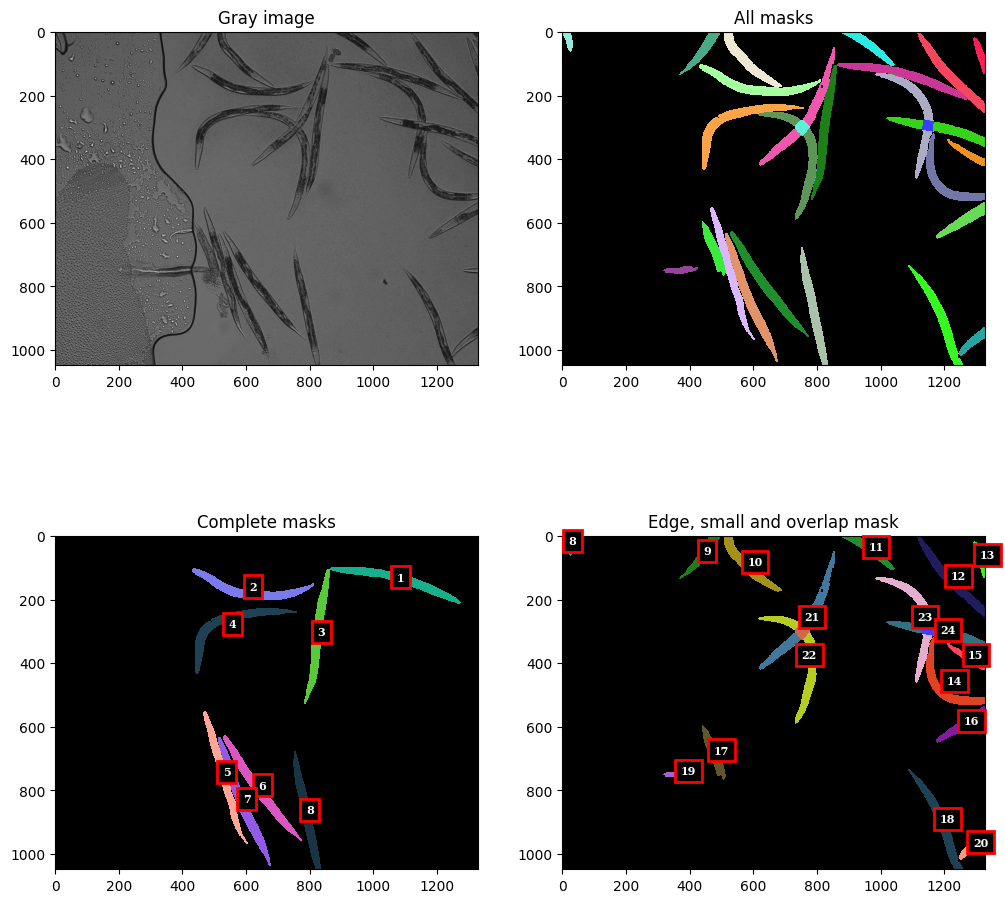

In [ ]:
#@title **Mask correction, saving and export**
#@markdown Correct complete, edge, small and overlapping masks and generate outputs
import warnings
warnings.filterwarnings('ignore')

name_image_change = 'Test (1).TIF' #@param {type:"string"}
print('Image selected:', name_image_change)
index_images = '1,2,3,4' #@param {type:"string"}

image_complete_mask_path = path_complete_mask + name_image_change
image_edge_small_mask_path = path_edge_small_mask + name_image_change

image_complete_mask_before = read_tiff_mask(image_complete_mask_path)
image_edge_small_mask_before = read_tiff_mask(image_edge_small_mask_path)

masK_predict_all = np.concatenate((image_complete_mask_before, image_edge_small_mask_before), axis=0)

try:
  image_overlap_mask = path_overlap + name_image_change
  image_overlap_mask = read_tiff_mask(image_overlap_mask)
  masK_predict_all = np.concatenate((masK_predict_all, image_overlap_mask), axis=0)
except:
  rt = -1

all_elements = []
for i in range(1, masK_predict_all.shape[0] + 1):
    all_elements.append(str(i))

index_images = index_images.split(',')

all_elements = all_elements + index_images

index_bad = [i for i in all_elements if all_elements.count(i) == 1]
print('Worms good: ', index_images)
print('Worms bad: ', index_bad)
worms_true = np.zeros((len(index_images), masK_predict_all.shape[1], masK_predict_all.shape[2]), np.int8)
for i in range(len(index_images)):
    index = int(index_images[i])
    worms_true[i, :, :] = masK_predict_all[index - 1, :, :]

worms_bad = np.zeros((len(index_bad), masK_predict_all.shape[1], masK_predict_all.shape[2]), np.int8)
for i in range(len(index_bad)):
    index = int(index_bad[i])
    worms_bad[i, :, :] = masK_predict_all[index - 1, :, :]

worms_true = (worms_true != 0) * 255
worms_bad = (worms_bad != 0) * 255

worms_all_true, new_map = Ndims2image(worms_true, 1)
worms_all_bad, _ = Ndims2image(worms_bad, 1)

centroid_predict_true, label_predict_true = get_centroid(worms_true, 1)
centroid_predict_bad, label_predict_bad = get_centroid(worms_bad, len(index_images))


tifffile.imwrite(image_complete_mask_path, worms_true.astype(np.uint8))
tifffile.imwrite(image_edge_small_mask_path, worms_bad.astype(np.uint8))
try:
  os.remove(path_overlap + name_image_change)
except:
  print('Files does not exist')


path_image_gray = test_images + name_image_change
image_gray = imread_image(path_image_gray)  # read gray image
if len(image_gray.shape) > 2:
    image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)
worms_all, new_map = Ndims2image(masK_predict_all, 1)

# show images results
font = {'family': 'serif',
        'color': 'white',
        'weight': 'bold',
        'size': 8,
        }

bbox = {'facecolor': 'black',
        'edgecolor': 'red',
        'linewidth': 2
        }

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax1.title.set_text('Gray image')
ax1.imshow(image_gray, cmap='gray', vmin=0, vmax=255)

ax2 = fig.add_subplot(222)
ax2.title.set_text('All masks')
ax2.imshow(worms_all, cmap=new_map, interpolation='None')

ax3 = fig.add_subplot(223)
ax3.title.set_text('Complete masks')
ax3.imshow(worms_all_true, cmap=new_map, interpolation='None')
for i in range(len(centroid_predict_true)):
    ax3.text(centroid_predict_true[i][1], centroid_predict_true[i][0], label_predict_true[i], fontdict=font, bbox=bbox)

ax4 = fig.add_subplot(224)
ax4.title.set_text('Edge, small and overlap mask')
ax4.imshow(worms_all_bad, cmap=new_map, interpolation='None')
for i in range(len(centroid_predict_bad)):
    ax4.text(centroid_predict_bad[i][1], centroid_predict_bad[i][0], label_predict_bad[i], fontdict=font, bbox=bbox)

name_image_change_ = name_image_change.split('.')[0]
name_image_result = path_save + name_image_change_ + 'Corrected.jpg'
plt.savefig(name_image_result)

fig = plt.gcf()
fig.set_size_inches(12, 12)

In [36]:
#@title **Save rois**
#@markdown Save complete mask in rois
folder_rois_results = '2_rois_results' #@param {type:"string"}
folder_rois_results = save_dir + '/' + folder_rois_results + '/'
print(folder_rois_results)

from utils import list_files, save_mask_rois
if not os.path.exists(folder_rois_results):
    os.makedirs(folder_rois_results)

list_images = sorted(list_files(path_complete_mask, end_gray_image))
with tqdm(total=len(list_images), unit='img') as pbar:
    for name_image in list_images:
        image_good_mask = path_complete_mask + name_image
        image_good_mask = read_tiff_mask(image_good_mask)
        name_image_ = name_image.split('.')[0]
        name_zip_save = folder_rois_results + name_image_ + '.zip'
        save_mask_rois(name_zip_save, image_good_mask)
        pbar.update(1)

/content/drive/MyDrive/Mask Images/pL/Output//2_rois_results/


100%|██████████| 28/28 [00:16<00:00,  1.74img/s]
